In [1]:
import pyforest

In [ ]:
df_path = '80train_20test/featurized/'
feat_types=['MOE','MFP']
samplings = ['none_scaled','UNDER','SMOTE']
model_types = ['GP', 'RF']
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
model_types = ['GP', 'RF']
RF_types = ['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW'] 
rf_path = 'RF_results/'
gp_path = '.'
results_list = []
cmpd_df_path = '.'
col_order = ['NEK', 'feat_type', 'strategy','modeling_type', 'compound_id', 'active', 'prediction' , 'RF_type']
for nek in neks:
    for feat in feat_types: 
        for samp in samplings: 
            full_df = pd.read_csv(f'{df_path}{nek}_{feat}_{samp}.csv')
            # train=full_df[full_df['subset']=='train'] 
            test=full_df[full_df['subset']=='test'] 
            
            test_cmpds = test[['compound_id', 'active']]
            for model in ['GP_matern']+ RF_types:
                if model == 'GP_matern': 
                    results = pd.read_csv(f'{gp_path}{nek}_{feat}_{samp}_matern_prod_test.csv')[['y_pred']]
                    results=results.rename(columns={'y_pred': 'prediction'})
                    results=results.rename(columns={'y': 'active'})
                    
                    gen_model_type = model
                    rf_type = 'N/A'
                    model_name=model
                    rf_type=model
                else: 
                    results=pd.read_csv(f'{rf_path}{nek}_{feat}_{samp}_{model}_prod_test.csv')[['prediction']]
                    gen_model_type = 'RF'
                    rf_type = model
                    model_name=rf_type 
            
                print(f'{nek} {feat} {samp} {model}')
                test_cmpds = test_cmpds.reset_index(drop=True)
                results = results.reset_index(drop=True)
                
                results_df = pd.concat([test_cmpds, results], axis=1)
                
                
                results_df['NEK'], results_df['feat_type'],results_df['strategy'] = nek,feat, samp
                results_df['modeling_type'],results_df['RF_type'] = gen_model_type, rf_type
                results_df=results_df[col_order]
                results_df['prediction_type'] = results_df.apply(lambda x:calc_pred_type(x['active'] ,x['prediction']), axis=1)
                results_df.to_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model_name}_cmpd_class.csv', index=False)
                display(results_df)
                print(results_df.columns)
                
#                 results_list.append(results_df) 
# final_results_df = pd.concat(results_list, ignore_index=True)


In [ ]:
for nek in neks:
    for feat in feat_types: 
        for samp in samplings: 
            full_df = pd.read_csv(f'{df_path}{nek}_{feat}_{samp}.csv')
            test=full_df[full_df['subset']=='test'] 
            
            test_cmpds = test[['compound_id', 'active']]
            results = pd.read_csv(f'{gp_path}{nek}_{feat}_{samp}_matern_prod_test.csv')[['y_pred']]
            results=results.rename(columns={'y_pred': 'prediction'})
            results=results.rename(columns={'y': 'active'})
            model='GP_matern'
            gen_model_type = model
            rf_type = 'N/A'
            model_name=model
            rf_type=model
                
            print(f'{nek} {feat} {samp} {model}')
            test_cmpds = test_cmpds.reset_index(drop=True)
            results = results.reset_index(drop=True)
            
            results_df = pd.concat([test_cmpds, results], axis=1)
            
            results_df['NEK'], results_df['feat_type'],results_df['strategy'] = nek,feat, samp
            results_df['modeling_type'],results_df['RF_type'] = gen_model_type, rf_type
            results_df=results_df[col_order]
            print(results_df.shape)
            
            results_df['prediction_type'] = results_df.apply(lambda x:calc_pred_type(x['active'] ,x['prediction']), axis=1)
            display(results_df)
            print(results_df.shape)
            results_df.to_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model_name}_cmpd_class.csv', index=False)
                

In [ ]:
gp_cols= ['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type']
rf_cols = ['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type']
def calc_pred_type(y_true, y_pred): 
    pred_type = 'err'
    if y_true == 0: 
        if y_pred == 1:
            pred_type='FP'
        else: 
            pred_type='TN'
    else: # if y_true==1
        if y_pred==0:
            pred_type='FN'
        else: 
            pred_type='TP'
    return pred_type

def len_lst(cmpd_lst):
    return len(cmpd_lst) 

cmpd_df_path = '.'
all_model_types=['GP_matern', 'RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']
col_order2=['NEK', 'feat_type', 'strategy', 'model', 'FN', 'TP', 'FP', 'TN', '#FN','#TP', '#FP', '#TN'] 
result_dfs=[] 
for nek in neks:
    for feat in feat_types: 
        for samp in samplings: 
            for model in all_model_types: 
                df = pd.read_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model}_cmpd_class.csv') 
                grouped_predtype = df.groupby('prediction_type')['compound_id'].apply(list).to_dict()
                # display(grouped_predtype)
                result_df = pd.DataFrame([{ 'TN':grouped_predtype.get('TN',[]),'FN':grouped_predtype.get('FN', []),
                    'FP': grouped_predtype.get('FP', []),'TP':grouped_predtype.get('TP', [])}])
                result_df['#FN'] = result_df.apply(lambda x:len_lst(x['FN']), axis=1)
                result_df['#TP'] = result_df.apply(lambda x:len_lst(x['TP']), axis=1)
                result_df['#FP'] = result_df.apply(lambda x:len_lst(x['FP']), axis=1)
                result_df['#TN'] = result_df.apply(lambda x:len_lst(x['TN']), axis=1)
                result_df['NEK'] = nek
                result_df['feat_type'] = feat
                result_df['strategy'] = samp
                result_df['model'] = model

                result_dfs.append(result_df)


final_df = pd.concat(result_dfs,ignore_index=True)[col_order2]
final_df.to_csv(f'{cmpd_df_path}list_of_mols_pred_types.csv',index=False)

Look at each model’s uncertainty for the exact same molecule in the test set


1. find all UQ metric values for test set compounds 
2. get all molecules that are used in the test set
3. make comparions across all models in the same test set (separate GP/RF)
4. maybe try comparing same models but different NEKs


The dfs were obtained from the notebook above

In [2]:
def get_tree_probabilities(model, x_data): 
    test_proba0_df = pd.DataFrame()
    test_proba1_df = pd.DataFrame()
    for tree_num in np.arange(len(model.estimators_)):
        test_proba_temp = model.estimators_[tree_num].predict_proba(x_data)
        test_proba0_df[tree_num] = test_proba_temp[:,0]
        test_proba1_df[tree_num] = test_proba_temp[:,1]
    std0 = test_proba0_df.std(axis=1)
    std1 = test_proba1_df.std(axis=1)
    return std0, std1

# RF model uncertainty: tree probability agreement

In [ ]:
df_path = 'datasets/80train_20test/featurized/'
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
model_types = ['GP', 'RF']
feat_types=['MOE','MFP']
RF_types = ['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW'] 
samplings = ['none_scaled','UNDER','SMOTE']
rf_path = 'RF_results/'
gp_path = 'GP_results/'
cmpd_df_path = '.'
col_order = ['NEK', 'feat_type', 'strategy','modeling_type', 'compound_id', 'active', 'prediction' , 'RF_type']


for nek in neks:
    for feat in feat_types: 
        for samp in samplings: 
            full_df = pd.read_csv(f'{df_path}{nek}_{feat}_{samp}.csv')
            test=full_df[full_df['subset']=='test'] 
            drop_cols=['NEK'	,'compound_id',	'base_rdkit_smiles',	'subset'	,'active']
            x_data=test.drop(columns=drop_cols).to_numpy()
     
            for rf in RF_types:
                with open(f'{rf_path}{nek}_{feat}_{samp}_{rf}_prod.pkl', 'rb') as f: 
                    model = pickle.load(f) 
                std0, std1=get_tree_probabilities(model, x_data)
                # print(f'{nek} {feat} {samp} {rf}')
                model_name=rf
                df = pd.read_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model_name}_cmpd_class.csv')
                
                df['uq_0']=std0 # use if 
                df['uq_1']=std1
             
                df['UQ_metric_value'] = df.apply(lambda x:x['uq_0'] if x['prediction_type'] in ['TN','FN'] else x['uq_1'], axis=1)
                df['model_version']=f'{samp}_{rf}'
                display(df)
                # df.to_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model_name}_cmpd_class.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MOE SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MOE SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MOE SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MOE SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MOE SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MOE SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE RF


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE RF_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE BRFC


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1',
       'UQ_metric_value', 'model_version'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE BRFC_BCW


<IPython.core.display.Javascript object>

Index(['NEK', 'feat_type', 'strategy', 'modeling_type', 'compound_id',
       'active', 'prediction', 'RF_type', 'prediction_type', 'uq_0', 'uq_1'],
      dtype='object')

In [6]:
def calc_pred_type(y_true, y_pred): 
    pred_type = 'err'
    if y_true == 0: 
        if y_pred == 1:
            pred_type='FP'
        else: 
            pred_type='TN'
    else: # if y_true==1
        if y_pred==0:
            pred_type='FN'
        else: 
            pred_type='TP'
    return pred_type

def len_lst(cmpd_lst):
    return len(cmpd_lst) 
    

# GP uncertainty: predictive variance

In [46]:
for nek in neks:
    for feat in feat_types: 
        for samp in samplings: 
            results_df = pd.read_csv(f'{gp_path}{nek}_{feat}_{samp}_matern_prod_test.csv')
            results_df=results_df.rename(columns={'y_pred': 'prediction'})
            results_df=results_df.rename(columns={'y': 'active'})
            results_df['prediction_type'] = results_df.apply(lambda x:calc_pred_type(x['active'] ,x['prediction']), axis=1)
      
            print(f'{nek} {feat} {samp} GP_matern')
            df = pd.read_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_GP_matern_cmpd_class.csv')
            
            df['prediction_type'] = df.apply(lambda x:calc_pred_type(x['active'] ,x['prediction']), axis=1)
            df['uq_0']=results_df['var_pred_class0']
            df['uq_1']=results_df['var_pred_class1']
         
         
            print(f'results df: {results_df.shape}, compound_df: {df.shape}')


            # df['UQ_metric_value'] = df.apply(lambda x:x['uq_0'] if x['prediction_type'] in ['TN','FN'] else x['uq_1'], axis=1)
            df['UQ_metric_value'] = df['uq_0']  # Default to uq_0
            df.loc[df['prediction_type'].isin(['TP', 'FP']), 'UQ_metric_value'] = df['uq_1']
            df['model_version']=f'{samp}_GP_matern'
            
            # df=df[col_order]
            display(df)
        
            df.to_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_GP_matern_cmpd_class.csv', index=False)


<IPython.core.display.Javascript object>

NEK2_binding MOE none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2562,0,0,GP_matern,TN,0.003433,2.596477,0.003433,none_scaled_GP_matern
1,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2854,0,0,GP_matern,TN,0.003433,2.341104,0.003433,none_scaled_GP_matern
2,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2631,0,0,GP_matern,TN,0.003433,2.252286,0.003433,none_scaled_GP_matern
3,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2754,0,0,GP_matern,TN,0.003433,2.249938,0.003433,none_scaled_GP_matern
4,NEK2_binding,MOE,none_scaled,GP_matern,kdb_3508,0,0,GP_matern,TN,0.003433,2.513501,0.003433,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2800,0,0,GP_matern,TN,0.003433,2.391440,0.003433,none_scaled_GP_matern
279,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2110,0,0,GP_matern,TN,0.003433,2.397524,0.003433,none_scaled_GP_matern
280,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2993,0,0,GP_matern,TN,0.003433,2.226584,0.003433,none_scaled_GP_matern
281,NEK2_binding,MOE,none_scaled,GP_matern,kdb_2219,0,0,GP_matern,TN,0.003433,2.089691,0.003433,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding MOE UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_binding,MOE,UNDER,GP_matern,kdb_2562,0,0,GP_matern,TN,8.098592,8.342371,8.098592,UNDER_GP_matern
1,NEK2_binding,MOE,UNDER,GP_matern,kdb_2854,0,0,GP_matern,TN,6.686061,6.740863,6.686061,UNDER_GP_matern
2,NEK2_binding,MOE,UNDER,GP_matern,kdb_2631,0,1,GP_matern,FP,6.726097,6.719210,6.719210,UNDER_GP_matern
3,NEK2_binding,MOE,UNDER,GP_matern,kdb_2754,0,0,GP_matern,TN,6.815008,6.850909,6.815008,UNDER_GP_matern
4,NEK2_binding,MOE,UNDER,GP_matern,kdb_3508,0,0,GP_matern,TN,7.596873,7.675554,7.596873,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK2_binding,MOE,UNDER,GP_matern,kdb_2800,0,0,GP_matern,TN,6.996218,7.053740,6.996218,UNDER_GP_matern
279,NEK2_binding,MOE,UNDER,GP_matern,kdb_2110,0,1,GP_matern,FP,7.136707,7.162715,7.162715,UNDER_GP_matern
280,NEK2_binding,MOE,UNDER,GP_matern,kdb_2993,0,1,GP_matern,FP,6.115880,6.048697,6.048697,UNDER_GP_matern
281,NEK2_binding,MOE,UNDER,GP_matern,kdb_2219,0,1,GP_matern,FP,5.735392,5.653219,5.653219,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding MOE SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2562,0,0,GP_matern,TN,1.795832,2.652049,1.795832,SMOTE_GP_matern
1,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2854,0,0,GP_matern,TN,1.629721,2.083638,1.629721,SMOTE_GP_matern
2,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2631,0,0,GP_matern,TN,1.610684,1.971866,1.610684,SMOTE_GP_matern
3,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2754,0,0,GP_matern,TN,1.591305,1.967272,1.591305,SMOTE_GP_matern
4,NEK2_binding,MOE,SMOTE,GP_matern,kdb_3508,0,0,GP_matern,TN,1.748560,2.398782,1.748560,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2800,0,0,GP_matern,TN,1.680043,2.193633,1.680043,SMOTE_GP_matern
279,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2110,0,0,GP_matern,TN,1.683406,2.181737,1.683406,SMOTE_GP_matern
280,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2993,0,0,GP_matern,TN,1.535572,1.868784,1.535572,SMOTE_GP_matern
281,NEK2_binding,MOE,SMOTE,GP_matern,kdb_2219,0,0,GP_matern,TN,1.451993,1.695938,1.451993,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_binding,MFP,none_scaled,GP_matern,kdb_115,0,0,GP_matern,TN,0.003498,2.316240,0.003498,none_scaled_GP_matern
1,NEK2_binding,MFP,none_scaled,GP_matern,kdb_120,0,0,GP_matern,TN,0.003490,2.294323,0.003490,none_scaled_GP_matern
2,NEK2_binding,MFP,none_scaled,GP_matern,kdb_1219,0,0,GP_matern,TN,0.003460,2.199173,0.003460,none_scaled_GP_matern
3,NEK2_binding,MFP,none_scaled,GP_matern,kdb_122,0,0,GP_matern,TN,0.003463,2.170324,0.003463,none_scaled_GP_matern
4,NEK2_binding,MFP,none_scaled,GP_matern,kdb_130,0,0,GP_matern,TN,0.003505,2.320542,0.003505,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK2_binding,MFP,none_scaled,GP_matern,kdb_2667,1,0,GP_matern,FN,0.003512,2.164462,0.003512,none_scaled_GP_matern
279,NEK2_binding,MFP,none_scaled,GP_matern,kdb_2696,1,0,GP_matern,FN,0.003437,1.944264,0.003437,none_scaled_GP_matern
280,NEK2_binding,MFP,none_scaled,GP_matern,kdb_2840,1,0,GP_matern,FN,0.003489,2.029201,0.003489,none_scaled_GP_matern
281,NEK2_binding,MFP,none_scaled,GP_matern,kdb_2863,1,0,GP_matern,FN,0.003477,2.218320,0.003477,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_binding,MFP,UNDER,GP_matern,kdb_115,0,0,GP_matern,TN,6.094263,6.462686,6.094263,UNDER_GP_matern
1,NEK2_binding,MFP,UNDER,GP_matern,kdb_120,0,0,GP_matern,TN,5.963104,6.316804,5.963104,UNDER_GP_matern
2,NEK2_binding,MFP,UNDER,GP_matern,kdb_1219,0,0,GP_matern,TN,5.603622,5.914193,5.603622,UNDER_GP_matern
3,NEK2_binding,MFP,UNDER,GP_matern,kdb_122,0,1,GP_matern,FP,5.429116,5.696453,5.696453,UNDER_GP_matern
4,NEK2_binding,MFP,UNDER,GP_matern,kdb_130,0,1,GP_matern,FP,6.126916,6.456748,6.456748,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK2_binding,MFP,UNDER,GP_matern,kdb_2667,1,1,GP_matern,TP,5.282145,5.338951,5.338951,UNDER_GP_matern
279,NEK2_binding,MFP,UNDER,GP_matern,kdb_2696,1,0,GP_matern,FN,5.033489,5.394893,5.033489,UNDER_GP_matern
280,NEK2_binding,MFP,UNDER,GP_matern,kdb_2840,1,1,GP_matern,TP,5.259268,5.144605,5.144605,UNDER_GP_matern
281,NEK2_binding,MFP,UNDER,GP_matern,kdb_2863,1,1,GP_matern,TP,5.445585,5.586480,5.586480,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_binding,MFP,SMOTE,GP_matern,kdb_115,0,0,GP_matern,TN,0.998863,2.566148,0.998863,SMOTE_GP_matern
1,NEK2_binding,MFP,SMOTE,GP_matern,kdb_120,0,0,GP_matern,TN,0.990385,2.543385,0.990385,SMOTE_GP_matern
2,NEK2_binding,MFP,SMOTE,GP_matern,kdb_1219,0,0,GP_matern,TN,0.942902,2.384656,0.942902,SMOTE_GP_matern
3,NEK2_binding,MFP,SMOTE,GP_matern,kdb_122,0,0,GP_matern,TN,0.914161,2.293955,0.914161,SMOTE_GP_matern
4,NEK2_binding,MFP,SMOTE,GP_matern,kdb_130,0,0,GP_matern,TN,0.998948,2.563244,0.998948,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK2_binding,MFP,SMOTE,GP_matern,kdb_2667,1,0,GP_matern,FN,0.910543,2.268522,0.910543,SMOTE_GP_matern
279,NEK2_binding,MFP,SMOTE,GP_matern,kdb_2696,1,0,GP_matern,FN,0.875412,2.048600,0.875412,SMOTE_GP_matern
280,NEK2_binding,MFP,SMOTE,GP_matern,kdb_2840,1,0,GP_matern,FN,0.934119,2.280196,0.934119,SMOTE_GP_matern
281,NEK2_binding,MFP,SMOTE,GP_matern,kdb_2863,1,0,GP_matern,FN,0.940454,2.373727,0.940454,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition MOE none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (407, 30), compound_df: (407, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_819,1,0,GP_matern,FN,0.004059,2.429407,0.004059,none_scaled_GP_matern
1,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_952,0,0,GP_matern,TN,0.004144,2.512741,0.004144,none_scaled_GP_matern
2,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_682,0,0,GP_matern,TN,0.004101,2.160717,0.004101,none_scaled_GP_matern
3,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_1216,0,0,GP_matern,TN,0.004065,2.346272,0.004065,none_scaled_GP_matern
4,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_481,0,0,GP_matern,TN,0.003908,1.951185,0.003908,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_1458,0,0,GP_matern,TN,0.004101,2.517400,0.004101,none_scaled_GP_matern
403,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_3179,0,0,GP_matern,TN,0.004175,2.464147,0.004175,none_scaled_GP_matern
404,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_794,0,0,GP_matern,TN,0.004216,2.722339,0.004216,none_scaled_GP_matern
405,NEK2_inhibition,MOE,none_scaled,GP_matern,kdb_687,0,0,GP_matern,TN,0.003975,2.195020,0.003975,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition MOE UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (407, 30), compound_df: (407, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_819,1,0,GP_matern,FN,4.410968,4.511440,4.410968,UNDER_GP_matern
1,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_952,0,0,GP_matern,TN,4.725529,4.900086,4.725529,UNDER_GP_matern
2,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_682,0,0,GP_matern,TN,3.825890,4.200973,3.825890,UNDER_GP_matern
3,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_1216,0,0,GP_matern,TN,4.096090,4.259102,4.096090,UNDER_GP_matern
4,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_481,0,0,GP_matern,TN,3.410392,3.618027,3.410392,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_1458,0,1,GP_matern,FP,4.403315,4.427013,4.427013,UNDER_GP_matern
403,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_3179,0,1,GP_matern,FP,4.660038,4.734085,4.734085,UNDER_GP_matern
404,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_794,0,1,GP_matern,FP,5.198132,5.297528,5.297528,UNDER_GP_matern
405,NEK2_inhibition,MOE,UNDER,GP_matern,kdb_687,0,0,GP_matern,TN,3.925496,4.103100,3.925496,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition MOE SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (407, 30), compound_df: (407, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_819,1,0,GP_matern,FN,1.534293,1.786766,1.534293,SMOTE_GP_matern
1,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_952,0,0,GP_matern,TN,1.594376,1.874760,1.594376,SMOTE_GP_matern
2,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_682,0,0,GP_matern,TN,1.404840,1.598724,1.404840,SMOTE_GP_matern
3,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_1216,0,0,GP_matern,TN,1.493183,1.720244,1.493183,SMOTE_GP_matern
4,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_481,0,0,GP_matern,TN,1.271107,1.421372,1.271107,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_1458,0,0,GP_matern,TN,1.552089,1.835367,1.552089,SMOTE_GP_matern
403,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_3179,0,0,GP_matern,TN,1.616884,1.888737,1.616884,SMOTE_GP_matern
404,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_794,0,0,GP_matern,TN,1.702613,2.100446,1.702613,SMOTE_GP_matern
405,NEK2_inhibition,MOE,SMOTE,GP_matern,kdb_687,0,0,GP_matern,TN,1.397576,1.611721,1.397576,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (407, 30), compound_df: (407, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_1025,0,0,GP_matern,TN,0.004361,1.985866,0.004361,none_scaled_GP_matern
1,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_1033,0,0,GP_matern,TN,0.004366,2.107877,0.004366,none_scaled_GP_matern
2,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_1035,0,0,GP_matern,TN,0.004394,2.163966,0.004394,none_scaled_GP_matern
3,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_1038,0,0,GP_matern,TN,0.004408,2.193615,0.004408,none_scaled_GP_matern
4,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_1051,0,0,GP_matern,TN,0.004359,1.933553,0.004359,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_749,1,0,GP_matern,FN,0.004426,2.188388,0.004426,none_scaled_GP_matern
403,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_819,1,0,GP_matern,FN,0.004391,2.206037,0.004391,none_scaled_GP_matern
404,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_840,1,0,GP_matern,FN,0.004467,1.940348,0.004467,none_scaled_GP_matern
405,NEK2_inhibition,MFP,none_scaled,GP_matern,kdb_872,1,0,GP_matern,FN,0.004457,2.247238,0.004457,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition MFP UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (407, 30), compound_df: (407, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_1025,0,0,GP_matern,TN,3.084826,3.588410,3.084826,UNDER_GP_matern
1,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_1033,0,0,GP_matern,TN,3.433812,3.745190,3.433812,UNDER_GP_matern
2,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_1035,0,0,GP_matern,TN,3.624437,3.987964,3.624437,UNDER_GP_matern
3,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_1038,0,0,GP_matern,TN,3.612981,3.959608,3.612981,UNDER_GP_matern
4,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_1051,0,1,GP_matern,FP,3.085664,3.255605,3.255605,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_749,1,0,GP_matern,FN,3.604157,3.967827,3.604157,UNDER_GP_matern
403,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_819,1,0,GP_matern,FN,3.623966,3.991525,3.623966,UNDER_GP_matern
404,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_840,1,1,GP_matern,TP,2.660530,2.544712,2.544712,UNDER_GP_matern
405,NEK2_inhibition,MFP,UNDER,GP_matern,kdb_872,1,1,GP_matern,TP,3.643520,3.922008,3.922008,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (407, 30), compound_df: (407, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_1025,0,0,GP_matern,TN,1.045572,2.002376,1.045572,SMOTE_GP_matern
1,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_1033,0,0,GP_matern,TN,0.996143,1.945407,0.996143,SMOTE_GP_matern
2,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_1035,0,0,GP_matern,TN,1.068963,2.104389,1.068963,SMOTE_GP_matern
3,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_1038,0,0,GP_matern,TN,1.073801,2.125965,1.073801,SMOTE_GP_matern
4,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_1051,0,0,GP_matern,TN,0.912788,1.766631,0.912788,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_749,1,0,GP_matern,FN,1.078379,2.121684,1.078379,SMOTE_GP_matern
403,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_819,1,0,GP_matern,FN,1.084540,2.138090,1.084540,SMOTE_GP_matern
404,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_840,1,1,GP_matern,TP,0.873428,1.680517,1.680517,SMOTE_GP_matern
405,NEK2_inhibition,MFP,SMOTE,GP_matern,kdb_872,1,0,GP_matern,FN,1.088797,2.136725,1.088797,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding MOE none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (282, 30), compound_df: (282, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK3_binding,MOE,none_scaled,GP_matern,kdb_2690,0,0,GP_matern,TN,0.003345,2.999337,0.003345,none_scaled_GP_matern
1,NEK3_binding,MOE,none_scaled,GP_matern,kdb_98,0,0,GP_matern,TN,0.003345,3.119935,0.003345,none_scaled_GP_matern
2,NEK3_binding,MOE,none_scaled,GP_matern,kdb_2082,0,0,GP_matern,TN,0.003345,2.817740,0.003345,none_scaled_GP_matern
3,NEK3_binding,MOE,none_scaled,GP_matern,kdb_2350,0,0,GP_matern,TN,0.003345,3.132774,0.003345,none_scaled_GP_matern
4,NEK3_binding,MOE,none_scaled,GP_matern,kdb_2655,0,0,GP_matern,TN,0.003345,3.146052,0.003345,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NEK3_binding,MOE,none_scaled,GP_matern,kdb_75,0,0,GP_matern,TN,0.003345,3.190020,0.003345,none_scaled_GP_matern
278,NEK3_binding,MOE,none_scaled,GP_matern,kdb_132,0,0,GP_matern,TN,0.003345,3.317659,0.003345,none_scaled_GP_matern
279,NEK3_binding,MOE,none_scaled,GP_matern,kdb_3049,0,0,GP_matern,TN,0.003345,2.959642,0.003345,none_scaled_GP_matern
280,NEK3_binding,MOE,none_scaled,GP_matern,kdb_2518,0,0,GP_matern,TN,0.003345,3.193593,0.003345,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding MOE UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (282, 30), compound_df: (282, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK3_binding,MOE,UNDER,GP_matern,kdb_2690,0,0,GP_matern,TN,7.542893,7.507177,7.542893,UNDER_GP_matern
1,NEK3_binding,MOE,UNDER,GP_matern,kdb_98,0,1,GP_matern,FP,7.594655,7.571588,7.571588,UNDER_GP_matern
2,NEK3_binding,MOE,UNDER,GP_matern,kdb_2082,0,1,GP_matern,FP,7.514028,7.448411,7.448411,UNDER_GP_matern
3,NEK3_binding,MOE,UNDER,GP_matern,kdb_2350,0,0,GP_matern,TN,7.566665,7.578420,7.566665,UNDER_GP_matern
4,NEK3_binding,MOE,UNDER,GP_matern,kdb_2655,0,1,GP_matern,FP,7.578360,7.552239,7.552239,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NEK3_binding,MOE,UNDER,GP_matern,kdb_75,0,0,GP_matern,TN,7.650352,7.644154,7.650352,UNDER_GP_matern
278,NEK3_binding,MOE,UNDER,GP_matern,kdb_132,0,0,GP_matern,TN,7.743826,7.737542,7.743826,UNDER_GP_matern
279,NEK3_binding,MOE,UNDER,GP_matern,kdb_3049,0,1,GP_matern,FP,7.713882,7.693845,7.693845,UNDER_GP_matern
280,NEK3_binding,MOE,UNDER,GP_matern,kdb_2518,0,1,GP_matern,FP,7.706217,7.695073,7.695073,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding MOE SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (282, 30), compound_df: (282, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK3_binding,MOE,SMOTE,GP_matern,kdb_2690,0,0,GP_matern,TN,2.179686,2.291452,2.179686,SMOTE_GP_matern
1,NEK3_binding,MOE,SMOTE,GP_matern,kdb_98,0,0,GP_matern,TN,2.329528,2.489866,2.329528,SMOTE_GP_matern
2,NEK3_binding,MOE,SMOTE,GP_matern,kdb_2082,0,0,GP_matern,TN,2.008295,2.014333,2.008295,SMOTE_GP_matern
3,NEK3_binding,MOE,SMOTE,GP_matern,kdb_2350,0,0,GP_matern,TN,2.345106,2.511436,2.345106,SMOTE_GP_matern
4,NEK3_binding,MOE,SMOTE,GP_matern,kdb_2655,0,0,GP_matern,TN,2.346293,2.528483,2.346293,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NEK3_binding,MOE,SMOTE,GP_matern,kdb_75,0,0,GP_matern,TN,2.426037,2.643534,2.426037,SMOTE_GP_matern
278,NEK3_binding,MOE,SMOTE,GP_matern,kdb_132,0,0,GP_matern,TN,2.563707,2.883643,2.563707,SMOTE_GP_matern
279,NEK3_binding,MOE,SMOTE,GP_matern,kdb_3049,0,0,GP_matern,TN,2.259918,2.350986,2.259918,SMOTE_GP_matern
280,NEK3_binding,MOE,SMOTE,GP_matern,kdb_2518,0,0,GP_matern,TN,2.450169,2.660513,2.450169,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (282, 30), compound_df: (282, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK3_binding,MFP,none_scaled,GP_matern,kdb_116,0,0,GP_matern,TN,0.003440,3.199608,0.003440,none_scaled_GP_matern
1,NEK3_binding,MFP,none_scaled,GP_matern,kdb_1219,0,0,GP_matern,TN,0.003408,3.073108,0.003408,none_scaled_GP_matern
2,NEK3_binding,MFP,none_scaled,GP_matern,kdb_123,0,0,GP_matern,TN,0.003427,3.169840,0.003427,none_scaled_GP_matern
3,NEK3_binding,MFP,none_scaled,GP_matern,kdb_1230,0,0,GP_matern,TN,0.003421,3.071718,0.003421,none_scaled_GP_matern
4,NEK3_binding,MFP,none_scaled,GP_matern,kdb_132,0,0,GP_matern,TN,0.003404,3.066147,0.003404,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NEK3_binding,MFP,none_scaled,GP_matern,kdb_2632,1,0,GP_matern,FN,0.003443,3.126929,0.003443,none_scaled_GP_matern
278,NEK3_binding,MFP,none_scaled,GP_matern,kdb_2996,1,0,GP_matern,FN,0.003428,2.916431,0.003428,none_scaled_GP_matern
279,NEK3_binding,MFP,none_scaled,GP_matern,kdb_3010,1,0,GP_matern,FN,0.003428,3.164435,0.003428,none_scaled_GP_matern
280,NEK3_binding,MFP,none_scaled,GP_matern,kdb_3023,1,0,GP_matern,FN,0.003370,2.708500,0.003370,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (282, 30), compound_df: (282, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK3_binding,MFP,UNDER,GP_matern,kdb_116,0,1,GP_matern,FP,7.097601,7.155093,7.155093,UNDER_GP_matern
1,NEK3_binding,MFP,UNDER,GP_matern,kdb_1219,0,0,GP_matern,TN,6.819770,6.891099,6.819770,UNDER_GP_matern
2,NEK3_binding,MFP,UNDER,GP_matern,kdb_123,0,0,GP_matern,TN,7.022383,7.088561,7.022383,UNDER_GP_matern
3,NEK3_binding,MFP,UNDER,GP_matern,kdb_1230,0,0,GP_matern,TN,6.982108,7.058165,6.982108,UNDER_GP_matern
4,NEK3_binding,MFP,UNDER,GP_matern,kdb_132,0,0,GP_matern,TN,6.765204,6.830951,6.765204,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NEK3_binding,MFP,UNDER,GP_matern,kdb_2632,1,1,GP_matern,TP,6.859591,6.836513,6.836513,UNDER_GP_matern
278,NEK3_binding,MFP,UNDER,GP_matern,kdb_2996,1,1,GP_matern,TP,6.240504,6.099698,6.099698,UNDER_GP_matern
279,NEK3_binding,MFP,UNDER,GP_matern,kdb_3010,1,0,GP_matern,FN,7.021206,7.082560,7.021206,UNDER_GP_matern
280,NEK3_binding,MFP,UNDER,GP_matern,kdb_3023,1,1,GP_matern,TP,6.246203,6.245897,6.245897,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (282, 30), compound_df: (282, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK3_binding,MFP,SMOTE,GP_matern,kdb_116,0,0,GP_matern,TN,1.082243,2.948703,1.082243,SMOTE_GP_matern
1,NEK3_binding,MFP,SMOTE,GP_matern,kdb_1219,0,0,GP_matern,TN,1.032234,2.744166,1.032234,SMOTE_GP_matern
2,NEK3_binding,MFP,SMOTE,GP_matern,kdb_123,0,0,GP_matern,TN,1.071875,2.907337,1.071875,SMOTE_GP_matern
3,NEK3_binding,MFP,SMOTE,GP_matern,kdb_1230,0,0,GP_matern,TN,1.042698,2.814341,1.042698,SMOTE_GP_matern
4,NEK3_binding,MFP,SMOTE,GP_matern,kdb_132,0,0,GP_matern,TN,1.025887,2.739073,1.025887,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NEK3_binding,MFP,SMOTE,GP_matern,kdb_2632,1,0,GP_matern,FN,1.036600,2.752826,1.036600,SMOTE_GP_matern
278,NEK3_binding,MFP,SMOTE,GP_matern,kdb_2996,1,1,GP_matern,TP,0.955229,2.431560,2.431560,SMOTE_GP_matern
279,NEK3_binding,MFP,SMOTE,GP_matern,kdb_3010,1,0,GP_matern,FN,1.071750,2.902004,1.071750,SMOTE_GP_matern
280,NEK3_binding,MFP,SMOTE,GP_matern,kdb_3023,1,0,GP_matern,FN,0.909897,2.269707,0.909897,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding MOE none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (248, 30), compound_df: (248, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK5_binding,MOE,none_scaled,GP_matern,kdb_2328,0,0,GP_matern,TN,0.003657,3.692457,0.003657,none_scaled_GP_matern
1,NEK5_binding,MOE,none_scaled,GP_matern,kdb_3496,0,0,GP_matern,TN,0.003573,3.322940,0.003573,none_scaled_GP_matern
2,NEK5_binding,MOE,none_scaled,GP_matern,kdb_1040,0,0,GP_matern,TN,0.003502,3.011937,0.003502,none_scaled_GP_matern
3,NEK5_binding,MOE,none_scaled,GP_matern,kdb_2388,0,0,GP_matern,TN,0.003568,3.237216,0.003568,none_scaled_GP_matern
4,NEK5_binding,MOE,none_scaled,GP_matern,kdb_2069,1,0,GP_matern,FN,0.003685,3.796483,0.003685,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NEK5_binding,MOE,none_scaled,GP_matern,kdb_2179,0,0,GP_matern,TN,0.003547,3.221332,0.003547,none_scaled_GP_matern
244,NEK5_binding,MOE,none_scaled,GP_matern,kdb_117,0,0,GP_matern,TN,0.003627,3.439920,0.003627,none_scaled_GP_matern
245,NEK5_binding,MOE,none_scaled,GP_matern,kdb_2862,0,0,GP_matern,TN,0.003536,3.088917,0.003536,none_scaled_GP_matern
246,NEK5_binding,MOE,none_scaled,GP_matern,kdb_2415,0,0,GP_matern,TN,0.003580,3.252574,0.003580,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding MOE UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (248, 30), compound_df: (248, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK5_binding,MOE,UNDER,GP_matern,kdb_2328,0,0,GP_matern,TN,6.414425,6.431502,6.414425,UNDER_GP_matern
1,NEK5_binding,MOE,UNDER,GP_matern,kdb_3496,0,0,GP_matern,TN,5.186320,5.159054,5.186320,UNDER_GP_matern
2,NEK5_binding,MOE,UNDER,GP_matern,kdb_1040,0,1,GP_matern,FP,4.565159,4.515627,4.515627,UNDER_GP_matern
3,NEK5_binding,MOE,UNDER,GP_matern,kdb_2388,0,0,GP_matern,TN,5.261205,5.276068,5.261205,UNDER_GP_matern
4,NEK5_binding,MOE,UNDER,GP_matern,kdb_2069,1,0,GP_matern,FN,7.031482,7.110607,7.031482,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NEK5_binding,MOE,UNDER,GP_matern,kdb_2179,0,0,GP_matern,TN,4.972251,4.888597,4.972251,UNDER_GP_matern
244,NEK5_binding,MOE,UNDER,GP_matern,kdb_117,0,0,GP_matern,TN,5.584209,5.588289,5.584209,UNDER_GP_matern
245,NEK5_binding,MOE,UNDER,GP_matern,kdb_2862,0,0,GP_matern,TN,4.421138,4.487292,4.421138,UNDER_GP_matern
246,NEK5_binding,MOE,UNDER,GP_matern,kdb_2415,0,1,GP_matern,FP,5.166521,5.048662,5.048662,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding MOE SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (248, 30), compound_df: (248, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK5_binding,MOE,SMOTE,GP_matern,kdb_2328,0,0,GP_matern,TN,2.442265,2.944530,2.442265,SMOTE_GP_matern
1,NEK5_binding,MOE,SMOTE,GP_matern,kdb_3496,0,0,GP_matern,TN,2.190631,2.411516,2.190631,SMOTE_GP_matern
2,NEK5_binding,MOE,SMOTE,GP_matern,kdb_1040,0,0,GP_matern,TN,1.975597,2.056846,1.975597,SMOTE_GP_matern
3,NEK5_binding,MOE,SMOTE,GP_matern,kdb_2388,0,0,GP_matern,TN,2.185092,2.373194,2.185092,SMOTE_GP_matern
4,NEK5_binding,MOE,SMOTE,GP_matern,kdb_2069,1,0,GP_matern,FN,2.512062,3.194014,2.512062,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NEK5_binding,MOE,SMOTE,GP_matern,kdb_2179,0,0,GP_matern,TN,2.119893,2.270038,2.119893,SMOTE_GP_matern
244,NEK5_binding,MOE,SMOTE,GP_matern,kdb_117,0,0,GP_matern,TN,2.291811,2.574624,2.291811,SMOTE_GP_matern
245,NEK5_binding,MOE,SMOTE,GP_matern,kdb_2862,0,0,GP_matern,TN,2.024747,2.150613,2.024747,SMOTE_GP_matern
246,NEK5_binding,MOE,SMOTE,GP_matern,kdb_2415,0,0,GP_matern,TN,2.146023,2.328564,2.146023,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (248, 30), compound_df: (248, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK5_binding,MFP,none_scaled,GP_matern,kdb_1040,0,0,GP_matern,TN,0.003619,2.806838,0.003619,none_scaled_GP_matern
1,NEK5_binding,MFP,none_scaled,GP_matern,kdb_117,0,0,GP_matern,TN,0.003648,2.943012,0.003648,none_scaled_GP_matern
2,NEK5_binding,MFP,none_scaled,GP_matern,kdb_1512,0,0,GP_matern,TN,0.003642,2.746980,0.003642,none_scaled_GP_matern
3,NEK5_binding,MFP,none_scaled,GP_matern,kdb_1612,0,0,GP_matern,TN,0.003634,2.890330,0.003634,none_scaled_GP_matern
4,NEK5_binding,MFP,none_scaled,GP_matern,kdb_1613,0,0,GP_matern,TN,0.003642,2.916702,0.003642,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NEK5_binding,MFP,none_scaled,GP_matern,kdb_2820,1,0,GP_matern,FN,0.003573,2.480682,0.003573,none_scaled_GP_matern
244,NEK5_binding,MFP,none_scaled,GP_matern,kdb_2894,1,0,GP_matern,FN,0.003648,2.898268,0.003648,none_scaled_GP_matern
245,NEK5_binding,MFP,none_scaled,GP_matern,kdb_2934,1,0,GP_matern,FN,0.003669,2.901646,0.003669,none_scaled_GP_matern
246,NEK5_binding,MFP,none_scaled,GP_matern,kdb_3052,1,0,GP_matern,FN,0.003647,2.584645,0.003647,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (248, 30), compound_df: (248, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK5_binding,MFP,UNDER,GP_matern,kdb_1040,0,0,GP_matern,TN,4.307493,4.418453,4.307493,UNDER_GP_matern
1,NEK5_binding,MFP,UNDER,GP_matern,kdb_117,0,0,GP_matern,TN,4.717956,4.775479,4.717956,UNDER_GP_matern
2,NEK5_binding,MFP,UNDER,GP_matern,kdb_1512,0,0,GP_matern,TN,4.501600,4.570977,4.501600,UNDER_GP_matern
3,NEK5_binding,MFP,UNDER,GP_matern,kdb_1612,0,0,GP_matern,TN,4.558810,4.642962,4.558810,UNDER_GP_matern
4,NEK5_binding,MFP,UNDER,GP_matern,kdb_1613,0,0,GP_matern,TN,4.739331,4.811389,4.739331,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NEK5_binding,MFP,UNDER,GP_matern,kdb_2820,1,0,GP_matern,FN,3.378400,3.622553,3.378400,UNDER_GP_matern
244,NEK5_binding,MFP,UNDER,GP_matern,kdb_2894,1,1,GP_matern,TP,4.620417,4.595470,4.595470,UNDER_GP_matern
245,NEK5_binding,MFP,UNDER,GP_matern,kdb_2934,1,1,GP_matern,TP,4.987964,4.996368,4.996368,UNDER_GP_matern
246,NEK5_binding,MFP,UNDER,GP_matern,kdb_3052,1,1,GP_matern,TP,3.406639,3.032025,3.032025,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (248, 30), compound_df: (248, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK5_binding,MFP,SMOTE,GP_matern,kdb_1040,0,0,GP_matern,TN,1.259739,2.533157,1.259739,SMOTE_GP_matern
1,NEK5_binding,MFP,SMOTE,GP_matern,kdb_117,0,0,GP_matern,TN,1.317163,2.694979,1.317163,SMOTE_GP_matern
2,NEK5_binding,MFP,SMOTE,GP_matern,kdb_1512,0,0,GP_matern,TN,1.269279,2.538655,1.269279,SMOTE_GP_matern
3,NEK5_binding,MFP,SMOTE,GP_matern,kdb_1612,0,0,GP_matern,TN,1.293315,2.650192,1.293315,SMOTE_GP_matern
4,NEK5_binding,MFP,SMOTE,GP_matern,kdb_1613,0,0,GP_matern,TN,1.316231,2.701544,1.316231,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,NEK5_binding,MFP,SMOTE,GP_matern,kdb_2820,1,0,GP_matern,FN,1.108299,2.163911,1.108299,SMOTE_GP_matern
244,NEK5_binding,MFP,SMOTE,GP_matern,kdb_2894,1,0,GP_matern,FN,1.299691,2.642026,1.299691,SMOTE_GP_matern
245,NEK5_binding,MFP,SMOTE,GP_matern,kdb_2934,1,0,GP_matern,FN,1.341009,2.744247,1.341009,SMOTE_GP_matern
246,NEK5_binding,MFP,SMOTE,GP_matern,kdb_3052,1,1,GP_matern,TP,0.938571,1.721947,1.721947,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding MOE none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2122,0,0,GP_matern,TN,0.003345,2.193634,0.003345,none_scaled_GP_matern
1,NEK9_binding,MOE,none_scaled,GP_matern,kdb_1612,0,0,GP_matern,TN,0.003369,2.421263,0.003369,none_scaled_GP_matern
2,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2155,0,0,GP_matern,TN,0.003352,2.315872,0.003352,none_scaled_GP_matern
3,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2425,0,0,GP_matern,TN,0.003366,2.319557,0.003366,none_scaled_GP_matern
4,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2397,0,0,GP_matern,TN,0.003423,2.503423,0.003423,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK9_binding,MOE,none_scaled,GP_matern,kdb_232,0,0,GP_matern,TN,0.003363,2.422312,0.003363,none_scaled_GP_matern
279,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2482,0,0,GP_matern,TN,0.003361,2.341553,0.003361,none_scaled_GP_matern
280,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2427,0,0,GP_matern,TN,0.003339,2.278037,0.003339,none_scaled_GP_matern
281,NEK9_binding,MOE,none_scaled,GP_matern,kdb_2693,0,0,GP_matern,TN,0.003409,2.545821,0.003409,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding MOE UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_binding,MOE,UNDER,GP_matern,kdb_2122,0,0,GP_matern,TN,6.575661,6.556742,6.575661,UNDER_GP_matern
1,NEK9_binding,MOE,UNDER,GP_matern,kdb_1612,0,0,GP_matern,TN,7.097529,6.972327,7.097529,UNDER_GP_matern
2,NEK9_binding,MOE,UNDER,GP_matern,kdb_2155,0,1,GP_matern,FP,6.644263,6.350541,6.350541,UNDER_GP_matern
3,NEK9_binding,MOE,UNDER,GP_matern,kdb_2425,0,0,GP_matern,TN,6.889855,6.754452,6.889855,UNDER_GP_matern
4,NEK9_binding,MOE,UNDER,GP_matern,kdb_2397,0,1,GP_matern,FP,7.320036,7.154550,7.154550,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK9_binding,MOE,UNDER,GP_matern,kdb_232,0,1,GP_matern,FP,7.054294,6.855638,6.855638,UNDER_GP_matern
279,NEK9_binding,MOE,UNDER,GP_matern,kdb_2482,0,1,GP_matern,FP,6.904707,6.670950,6.670950,UNDER_GP_matern
280,NEK9_binding,MOE,UNDER,GP_matern,kdb_2427,0,0,GP_matern,TN,6.780689,6.621040,6.780689,UNDER_GP_matern
281,NEK9_binding,MOE,UNDER,GP_matern,kdb_2693,0,0,GP_matern,TN,7.266567,7.132941,7.266567,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding MOE SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2122,0,0,GP_matern,TN,1.717338,1.830062,1.717338,SMOTE_GP_matern
1,NEK9_binding,MOE,SMOTE,GP_matern,kdb_1612,0,0,GP_matern,TN,1.904168,2.123364,1.904168,SMOTE_GP_matern
2,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2155,0,0,GP_matern,TN,1.745057,1.851282,1.745057,SMOTE_GP_matern
3,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2425,0,0,GP_matern,TN,1.814860,1.972424,1.814860,SMOTE_GP_matern
4,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2397,0,0,GP_matern,TN,2.021614,2.285329,2.021614,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK9_binding,MOE,SMOTE,GP_matern,kdb_232,0,0,GP_matern,TN,1.934872,2.131514,1.934872,SMOTE_GP_matern
279,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2482,0,0,GP_matern,TN,1.837762,1.981257,1.837762,SMOTE_GP_matern
280,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2427,0,0,GP_matern,TN,1.756517,1.896221,1.756517,SMOTE_GP_matern
281,NEK9_binding,MOE,SMOTE,GP_matern,kdb_2693,0,0,GP_matern,TN,2.056636,2.350608,2.056636,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_binding,MFP,none_scaled,GP_matern,kdb_117,0,0,GP_matern,TN,0.003495,2.365943,0.003495,none_scaled_GP_matern
1,NEK9_binding,MFP,none_scaled,GP_matern,kdb_1219,0,0,GP_matern,TN,0.003473,2.308326,0.003473,none_scaled_GP_matern
2,NEK9_binding,MFP,none_scaled,GP_matern,kdb_123,0,0,GP_matern,TN,0.003494,2.388449,0.003494,none_scaled_GP_matern
3,NEK9_binding,MFP,none_scaled,GP_matern,kdb_1230,0,0,GP_matern,TN,0.003486,2.168056,0.003486,none_scaled_GP_matern
4,NEK9_binding,MFP,none_scaled,GP_matern,kdb_1325,0,0,GP_matern,TN,0.003504,2.401122,0.003504,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK9_binding,MFP,none_scaled,GP_matern,kdb_2673,1,0,GP_matern,FN,0.003455,2.039355,0.003455,none_scaled_GP_matern
279,NEK9_binding,MFP,none_scaled,GP_matern,kdb_2768,1,0,GP_matern,FN,0.003468,2.237510,0.003468,none_scaled_GP_matern
280,NEK9_binding,MFP,none_scaled,GP_matern,kdb_2845,1,0,GP_matern,FN,0.003500,2.335555,0.003500,none_scaled_GP_matern
281,NEK9_binding,MFP,none_scaled,GP_matern,kdb_3053,1,0,GP_matern,FN,0.003492,2.097635,0.003492,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding MFP UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_binding,MFP,UNDER,GP_matern,kdb_117,0,1,GP_matern,FP,6.009699,6.153206,6.153206,UNDER_GP_matern
1,NEK9_binding,MFP,UNDER,GP_matern,kdb_1219,0,0,GP_matern,TN,5.853951,6.038153,5.853951,UNDER_GP_matern
2,NEK9_binding,MFP,UNDER,GP_matern,kdb_123,0,0,GP_matern,TN,6.103921,6.284203,6.103921,UNDER_GP_matern
3,NEK9_binding,MFP,UNDER,GP_matern,kdb_1230,0,0,GP_matern,TN,6.077064,6.274386,6.077064,UNDER_GP_matern
4,NEK9_binding,MFP,UNDER,GP_matern,kdb_1325,0,0,GP_matern,TN,6.234141,6.400926,6.234141,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK9_binding,MFP,UNDER,GP_matern,kdb_2673,1,0,GP_matern,FN,5.076227,5.319517,5.076227,UNDER_GP_matern
279,NEK9_binding,MFP,UNDER,GP_matern,kdb_2768,1,1,GP_matern,TP,5.552879,5.654312,5.654312,UNDER_GP_matern
280,NEK9_binding,MFP,UNDER,GP_matern,kdb_2845,1,1,GP_matern,TP,6.085446,6.255357,6.255357,UNDER_GP_matern
281,NEK9_binding,MFP,UNDER,GP_matern,kdb_3053,1,1,GP_matern,TP,5.109514,4.813130,4.813130,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (283, 30), compound_df: (283, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_binding,MFP,SMOTE,GP_matern,kdb_117,0,0,GP_matern,TN,1.093621,2.628384,1.093621,SMOTE_GP_matern
1,NEK9_binding,MFP,SMOTE,GP_matern,kdb_1219,0,0,GP_matern,TN,1.065124,2.539756,1.065124,SMOTE_GP_matern
2,NEK9_binding,MFP,SMOTE,GP_matern,kdb_123,0,0,GP_matern,TN,1.106331,2.676661,1.106331,SMOTE_GP_matern
3,NEK9_binding,MFP,SMOTE,GP_matern,kdb_1230,0,0,GP_matern,TN,1.039402,2.445410,1.039402,SMOTE_GP_matern
4,NEK9_binding,MFP,SMOTE,GP_matern,kdb_1325,0,0,GP_matern,TN,1.117243,2.696202,1.117243,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NEK9_binding,MFP,SMOTE,GP_matern,kdb_2673,1,0,GP_matern,FN,0.964266,2.243766,0.964266,SMOTE_GP_matern
279,NEK9_binding,MFP,SMOTE,GP_matern,kdb_2768,1,0,GP_matern,FN,1.010422,2.391963,1.010422,SMOTE_GP_matern
280,NEK9_binding,MFP,SMOTE,GP_matern,kdb_2845,1,0,GP_matern,FN,1.096720,2.601760,1.096720,SMOTE_GP_matern
281,NEK9_binding,MFP,SMOTE,GP_matern,kdb_3053,1,0,GP_matern,FN,1.005195,2.330819,1.005195,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition MOE none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (80, 30), compound_df: (80, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3330,0,0,GP_matern,TN,0.003899,2.705134,0.003899,none_scaled_GP_matern
1,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3294,0,0,GP_matern,TN,0.003913,2.923077,0.003913,none_scaled_GP_matern
2,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3296,0,0,GP_matern,TN,0.003917,2.969297,0.003917,none_scaled_GP_matern
3,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3328,0,0,GP_matern,TN,0.003906,2.836888,0.003906,none_scaled_GP_matern
4,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3119,0,0,GP_matern,TN,0.003939,3.318921,0.003939,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3232,0,0,GP_matern,TN,0.003891,2.647664,0.003891,none_scaled_GP_matern
76,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3374,0,0,GP_matern,TN,0.003899,2.632653,0.003899,none_scaled_GP_matern
77,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3284,0,0,GP_matern,TN,0.003915,2.999034,0.003915,none_scaled_GP_matern
78,NEK9_inhibition,MOE,none_scaled,GP_matern,kdb_3762,1,0,GP_matern,FN,0.003900,2.398374,0.003900,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition MOE UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (80, 30), compound_df: (80, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3330,0,0,GP_matern,TN,5.352763,4.889912,5.352763,UNDER_GP_matern
1,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3294,0,0,GP_matern,TN,5.351185,4.857726,5.351185,UNDER_GP_matern
2,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3296,0,0,GP_matern,TN,5.339003,5.035092,5.339003,UNDER_GP_matern
3,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3328,0,0,GP_matern,TN,5.574126,5.170521,5.574126,UNDER_GP_matern
4,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3119,0,0,GP_matern,TN,6.506331,6.348572,6.506331,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3232,0,0,GP_matern,TN,4.859009,4.401834,4.859009,UNDER_GP_matern
76,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3374,0,0,GP_matern,TN,4.774899,4.420052,4.774899,UNDER_GP_matern
77,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3284,0,0,GP_matern,TN,5.625448,5.233320,5.625448,UNDER_GP_matern
78,NEK9_inhibition,MOE,UNDER,GP_matern,kdb_3762,1,1,GP_matern,TP,4.187126,3.452120,3.452120,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition MOE SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (80, 30), compound_df: (80, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3330,0,0,GP_matern,TN,1.570286,1.760934,1.570286,SMOTE_GP_matern
1,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3294,0,0,GP_matern,TN,1.725958,1.906638,1.725958,SMOTE_GP_matern
2,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3296,0,0,GP_matern,TN,1.740879,1.961337,1.740879,SMOTE_GP_matern
3,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3328,0,0,GP_matern,TN,1.656617,1.861843,1.656617,SMOTE_GP_matern
4,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3119,0,0,GP_matern,TN,1.889835,2.266214,1.889835,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3232,0,0,GP_matern,TN,1.561206,1.709623,1.561206,SMOTE_GP_matern
76,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3374,0,0,GP_matern,TN,1.538022,1.710460,1.538022,SMOTE_GP_matern
77,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3284,0,0,GP_matern,TN,1.768781,1.979361,1.768781,SMOTE_GP_matern
78,NEK9_inhibition,MOE,SMOTE,GP_matern,kdb_3762,1,1,GP_matern,TP,1.433504,1.418914,1.418914,SMOTE_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition MFP none_scaled GP_matern


<IPython.core.display.Javascript object>

results df: (80, 30), compound_df: (80, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_2013,0,0,GP_matern,TN,0.004031,2.557131,0.004031,none_scaled_GP_matern
1,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_2205,0,0,GP_matern,TN,0.004059,2.702081,0.004059,none_scaled_GP_matern
2,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_2212,0,0,GP_matern,TN,0.004046,2.700486,0.004046,none_scaled_GP_matern
3,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_2227,0,0,GP_matern,TN,0.004010,2.174567,0.004010,none_scaled_GP_matern
4,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_2230,0,0,GP_matern,TN,0.004005,2.249633,0.004005,none_scaled_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_3756,1,0,GP_matern,FN,0.004036,2.047753,0.004036,none_scaled_GP_matern
76,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_3757,1,0,GP_matern,FN,0.004041,1.922648,0.004041,none_scaled_GP_matern
77,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_3761,1,0,GP_matern,FN,0.004038,2.372290,0.004038,none_scaled_GP_matern
78,NEK9_inhibition,MFP,none_scaled,GP_matern,kdb_3762,1,0,GP_matern,FN,0.004040,1.852117,0.004040,none_scaled_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition MFP UNDER GP_matern


<IPython.core.display.Javascript object>

results df: (80, 30), compound_df: (80, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_2013,0,0,GP_matern,TN,4.659319,4.438769,4.659319,UNDER_GP_matern
1,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_2205,0,0,GP_matern,TN,5.379687,5.156948,5.379687,UNDER_GP_matern
2,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_2212,0,0,GP_matern,TN,5.097590,4.904475,5.097590,UNDER_GP_matern
3,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_2227,0,0,GP_matern,TN,4.451092,4.251620,4.451092,UNDER_GP_matern
4,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_2230,0,0,GP_matern,TN,3.877040,3.805879,3.877040,UNDER_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_3756,1,1,GP_matern,TP,3.378089,2.798802,2.798802,UNDER_GP_matern
76,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_3757,1,1,GP_matern,TP,3.195426,2.560358,2.560358,UNDER_GP_matern
77,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_3761,1,1,GP_matern,TP,3.945334,3.448399,3.448399,UNDER_GP_matern
78,NEK9_inhibition,MFP,UNDER,GP_matern,kdb_3762,1,1,GP_matern,TP,3.075563,2.403806,2.403806,UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition MFP SMOTE GP_matern


<IPython.core.display.Javascript object>

results df: (80, 30), compound_df: (80, 11)


,NEK,feat_type,strategy,modeling_type,compound_id,active,prediction,RF_type,prediction_type,uq_0,uq_1,UQ_metric_value,model_version
0,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_2013,0,0,GP_matern,TN,1.330402,2.244783,1.330402,SMOTE_GP_matern
1,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_2205,0,0,GP_matern,TN,1.400087,2.398173,1.400087,SMOTE_GP_matern
2,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_2212,0,0,GP_matern,TN,1.439613,2.395098,1.439613,SMOTE_GP_matern
3,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_2227,0,0,GP_matern,TN,1.078580,1.870674,1.078580,SMOTE_GP_matern
4,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_2230,0,0,GP_matern,TN,1.157276,1.932692,1.157276,SMOTE_GP_matern
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_3756,1,1,GP_matern,TP,1.067586,1.512621,1.512621,SMOTE_GP_matern
76,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_3757,1,1,GP_matern,TP,1.036764,1.444731,1.444731,SMOTE_GP_matern
77,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_3761,1,1,GP_matern,TP,1.305557,1.958750,1.958750,SMOTE_GP_matern
78,NEK9_inhibition,MFP,SMOTE,GP_matern,kdb_3762,1,1,GP_matern,TP,1.064595,1.387536,1.387536,SMOTE_GP_matern


In [75]:
# make df of all models for 1 nek 
all_uq_dfs = []
for nek in neks:
    nek_df=[]
    for feat in feat_types: 
        for samp in samplings: 
            for model in ['GP_matern']+ RF_types:
                df = pd.read_csv(f'{cmpd_df_path}{nek}_{feat}_{samp}_{model}_cmpd_class.csv')
                df['NEK']=nek
                df['feat_type'] =feat
                df['strategy']=samp
                df['model']=model
                all_uq_dfs.append(df)
uq_df = pd.concat(all_uq_dfs, ignore_index=True)
uq_df.to_csv(f'{cmpd_df_path}UQ_all_mols_all_models.csv', index=False)       
    #             nek_df.append(df)
    # full_df=pd.concat(nek_df,axis=0)
    # full_df.to_csv(f'{cmpd_df_path}{nek}_all_models.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Find all common compounds in test sets for 1 nek at a time

# plot for classifcation types (TP, FP, etc.)

In [77]:
uq_df['model_version'] = uq_df['strategy'].astype(str)+'_'+uq_df['modeling_type']+'_'+uq_df['feat_type']

In [80]:
uq_df['model_version'].value_counts()

model_version
SMOTE_RF_MFP                 4749
UNDER_RF_MOE                 4749
UNDER_RF_MFP                 4749
SMOTE_RF_MOE                 4749
none_scaled_RF_MOE           4749
none_scaled_RF_MFP           4749
none_scaled_GP_matern_MOE    1583
none_scaled_BRFC_BCW_MFP     1583
SMOTE_GP_matern_MFP          1583
UNDER_BRFC_BCW_MFP           1583
UNDER_GP_matern_MFP          1583
none_scaled_GP_matern_MFP    1583
SMOTE_BRFC_BCW_MOE           1583
SMOTE_GP_matern_MOE          1583
UNDER_BRFC_BCW_MOE           1583
UNDER_GP_matern_MOE          1583
none_scaled_BRFC_BCW_MOE     1583
SMOTE_BRFC_BCW_MFP           1583
Name: count, dtype: int64

In [145]:
model_shapes = {'UNDER_GP_matern': 'o', 'none_scaled_BRFC': 's','none_scaled_BRFC_BCW':'s'}
pred_types = {'TN': 'gray','FN': 'red', 'TP': 'green','FP': 'orange'}

NEK2_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

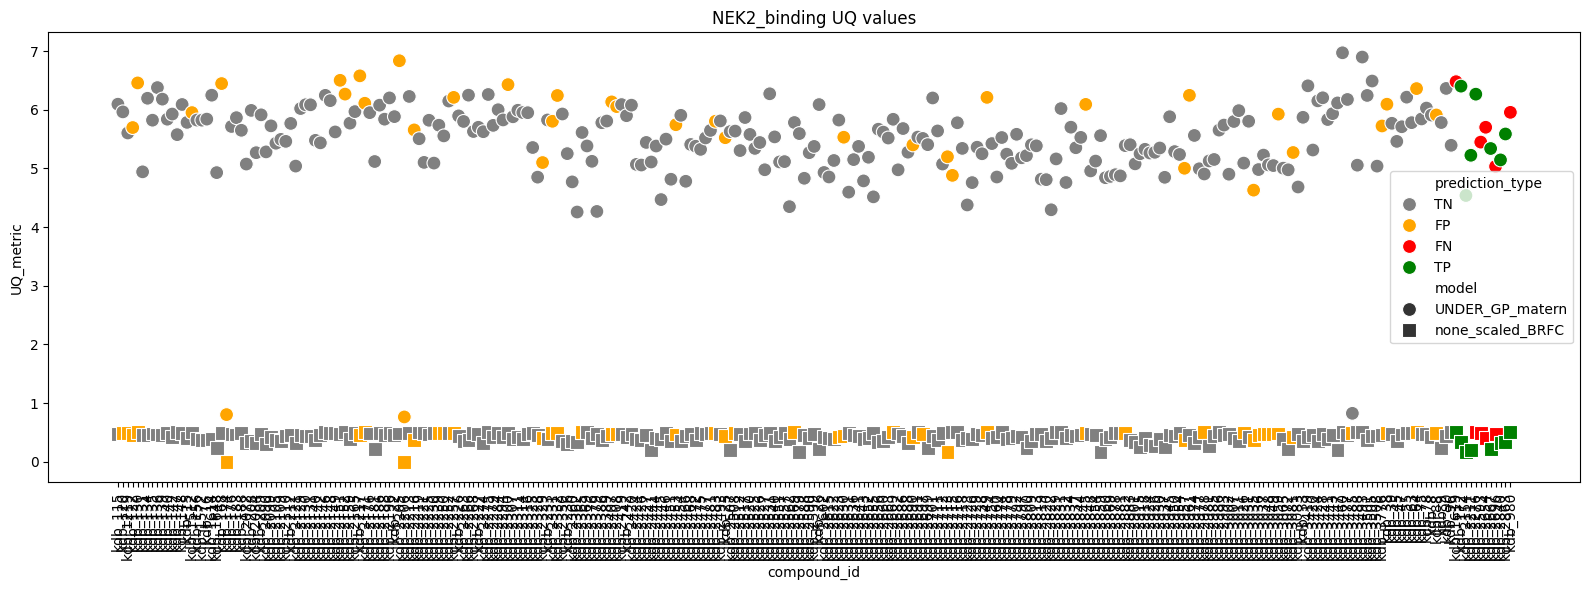

NEK2_inhibition UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

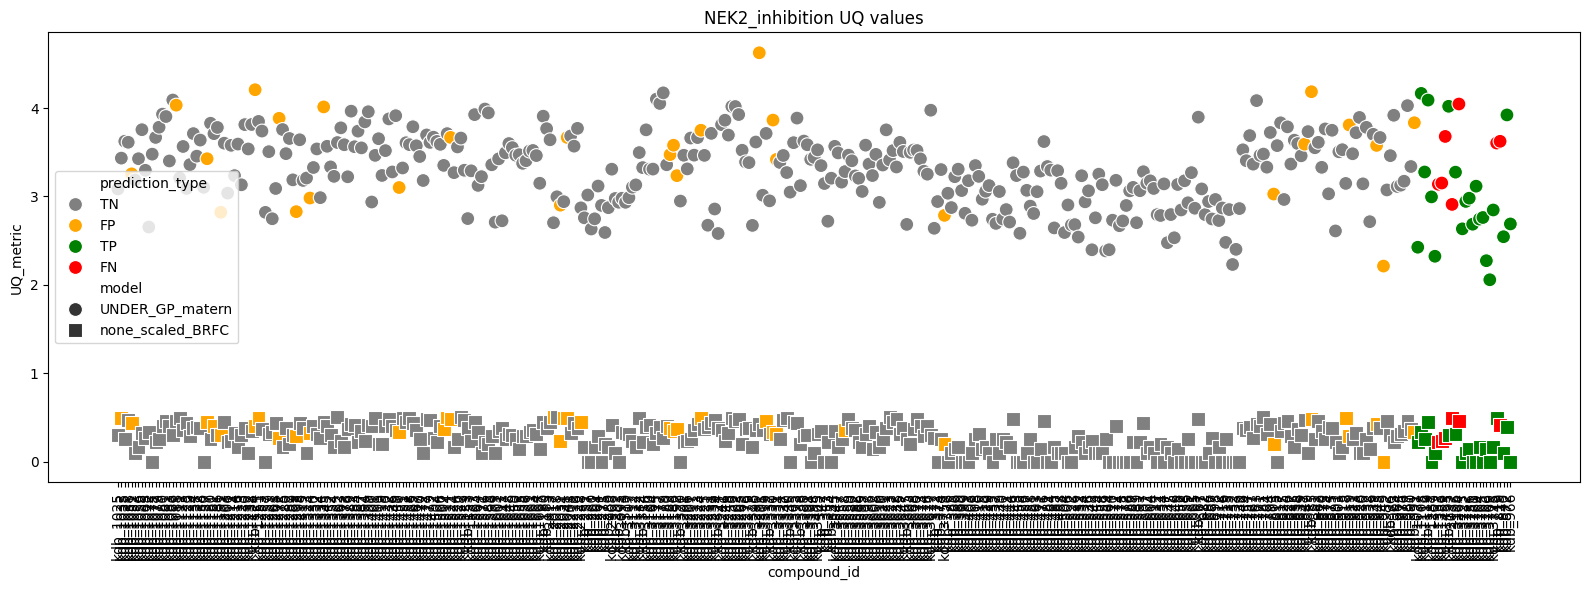

NEK3_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

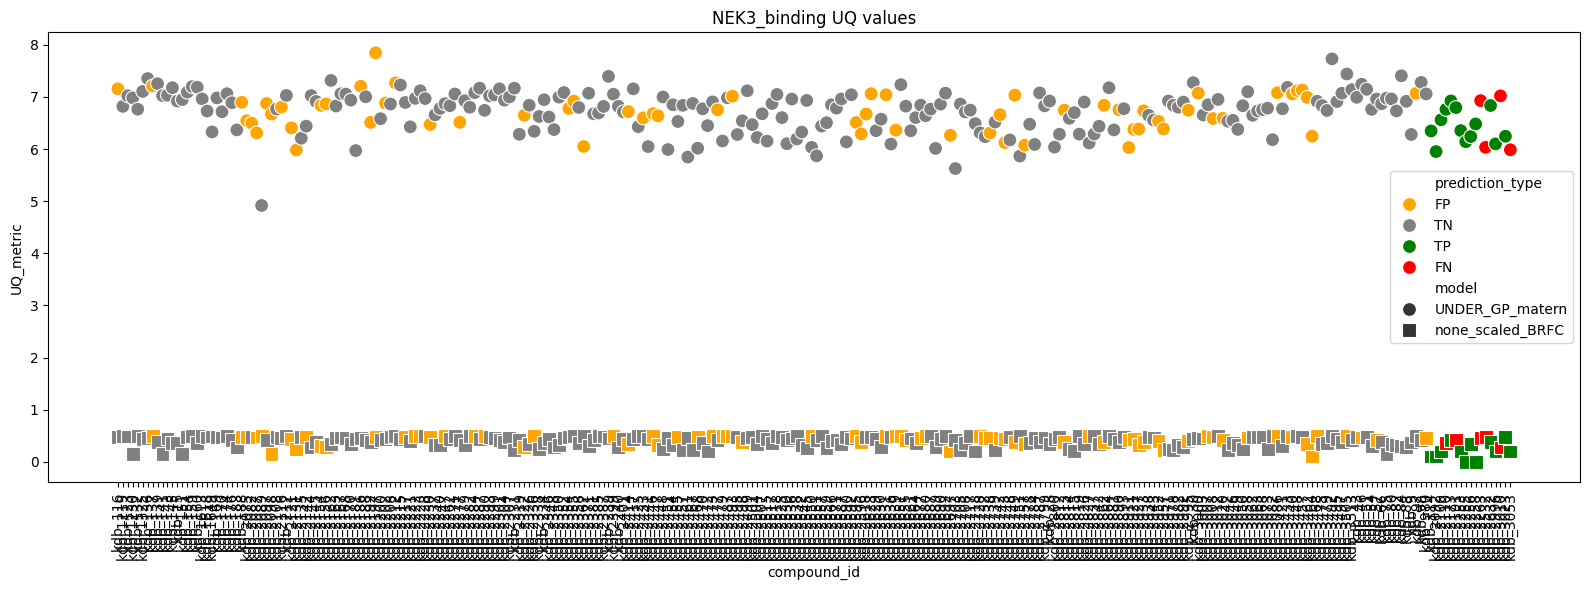

NEK5_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

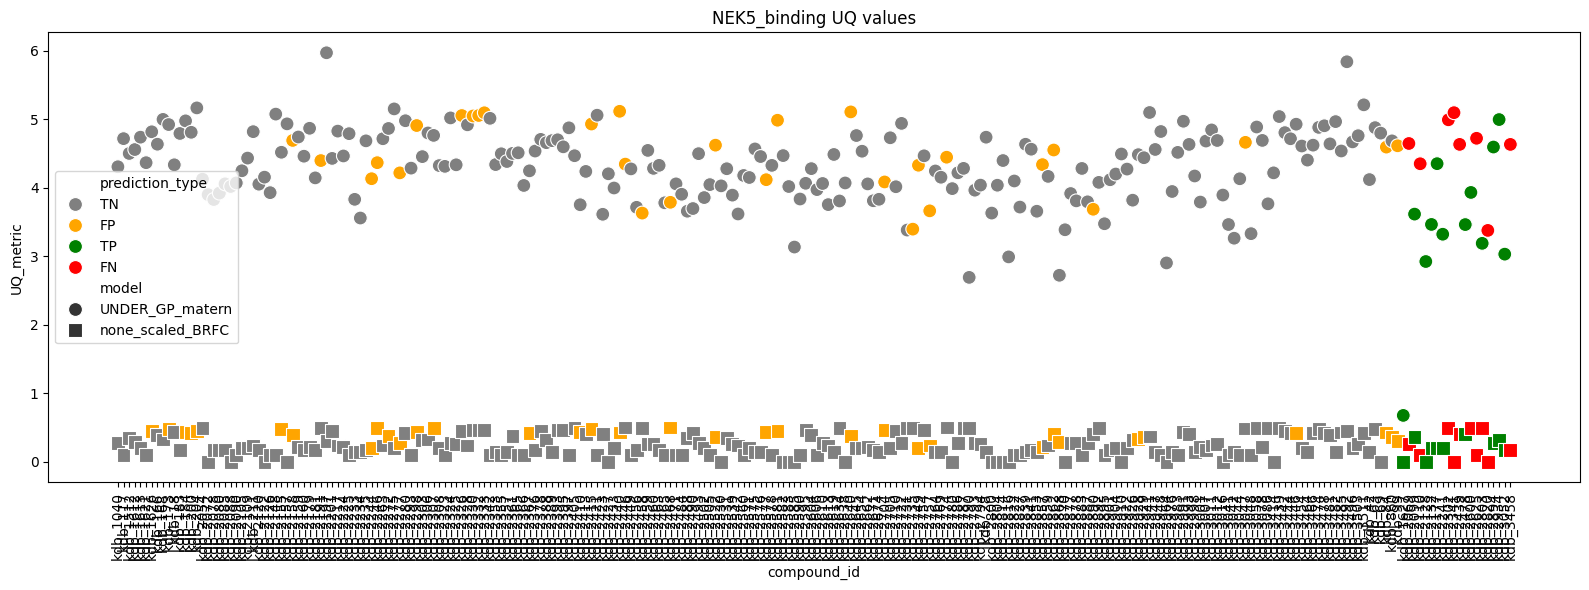

NEK9_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

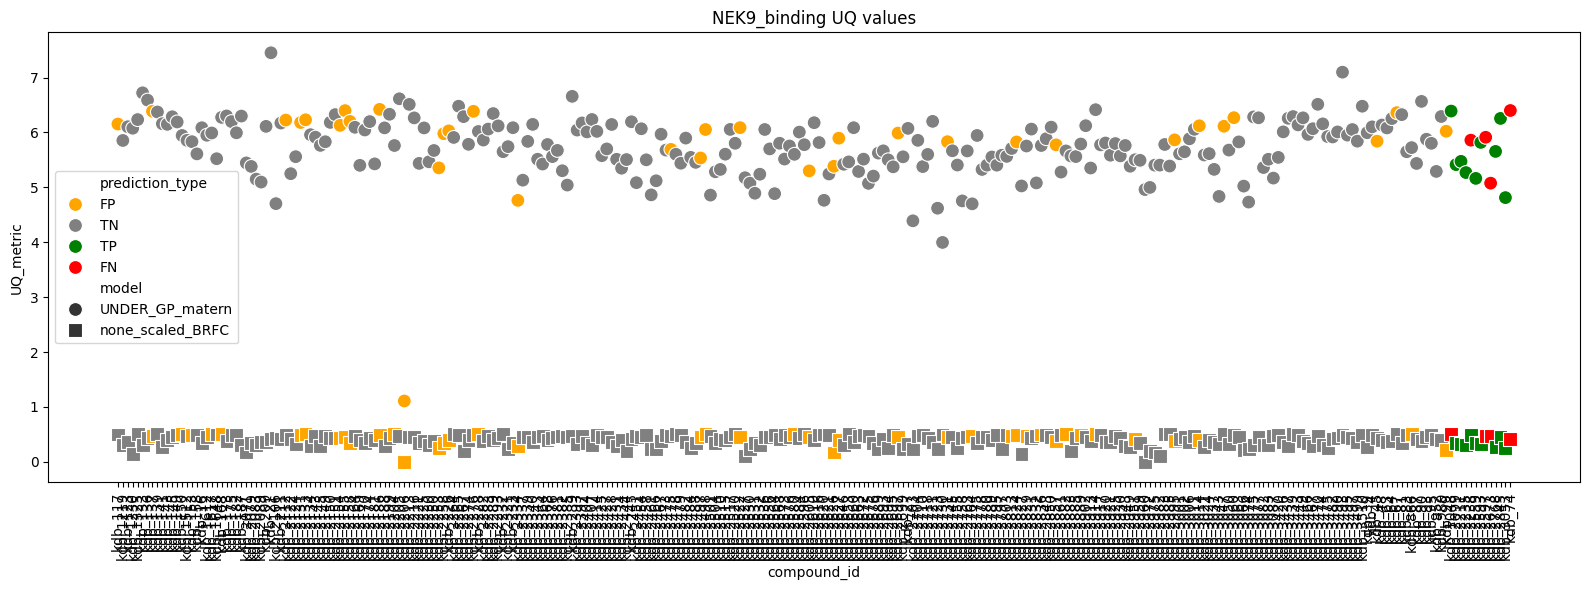

NEK9_inhibition UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition none_scaled_BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

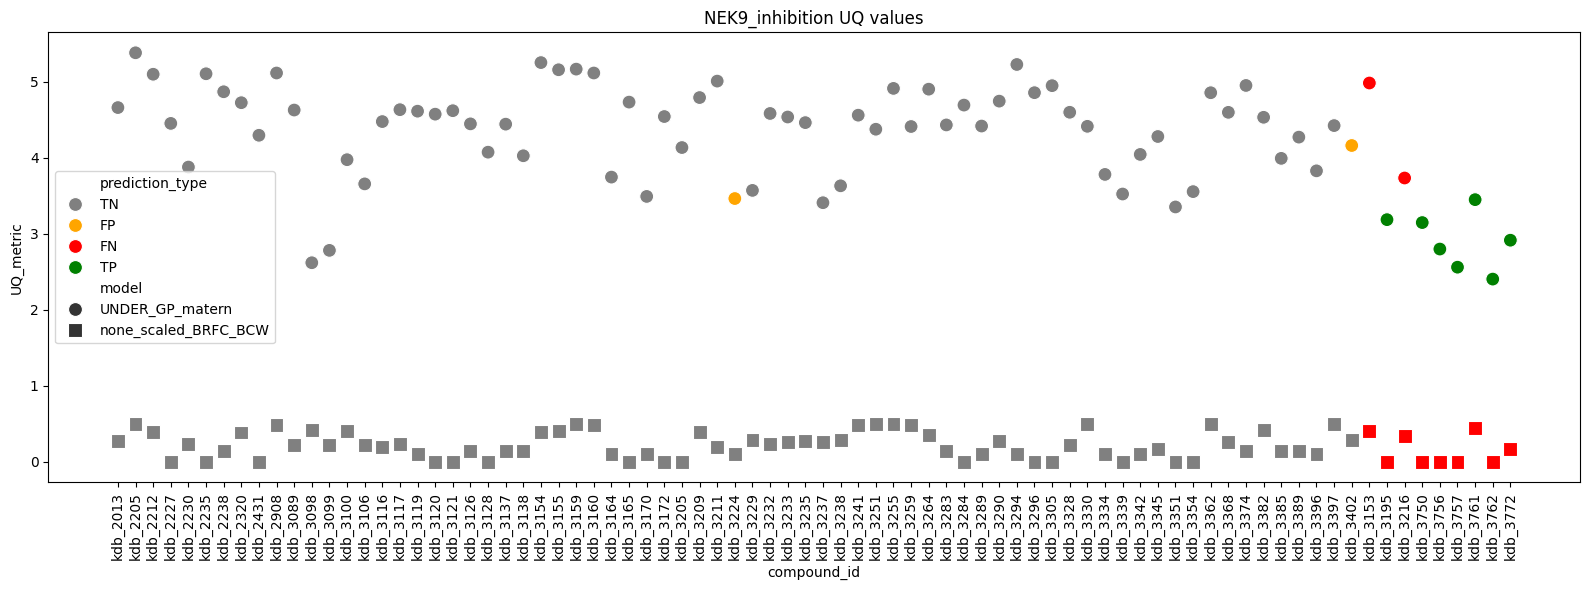

In [187]:
fig_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/UQ_point_comparison/'
for nek in neks:
    df_list = []
    model_list=[]
    for model in ['UNDER_GP_matern','none_scaled_BRFC'] : 
        
        if (nek=='NEK9_inhibition' and model=='none_scaled_BRFC'): 
            model ='none_scaled_BRFC_BCW'
        print(nek, model)
        model_list.append(model)
        df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{model}_cmpd_class.csv')
   
        df_list.append(df) 
    
    merged = df_list[0].merge(df_list[1], on=['compound_id'], suffixes=('_GP', '_RF'))
    # display(nek_df)
    # display(merged)
    plot_df = pd.DataFrame({'compound_id':pd.concat([merged['compound_id'],merged['compound_id']]),
    'model': [model_list[0]] * len(merged)+ [model_list[1]]*len(merged),
    'UQ_metric': pd.concat([merged['UQ_metric_value_GP'], merged['UQ_metric_value_RF']]),
    'prediction_type': pd.concat([merged['prediction_type_GP'], merged['prediction_type_RF']])})
    # display(plot_df)
    plt.figure(figsize=(16, 6))
    sns.scatterplot(data=plot_df,x='compound_id',y='UQ_metric',hue='prediction_type',palette=pred_types,
        style='model',markers=model_shapes, s=100)
    plt.xticks(rotation=90)
    plt.title(f'{nek} UQ values')
    plt.tight_layout()
    plt.savefig(f"{fig_path}{nek}.png", bbox_inches='tight')
    plt.show()
    
        

NEK2_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

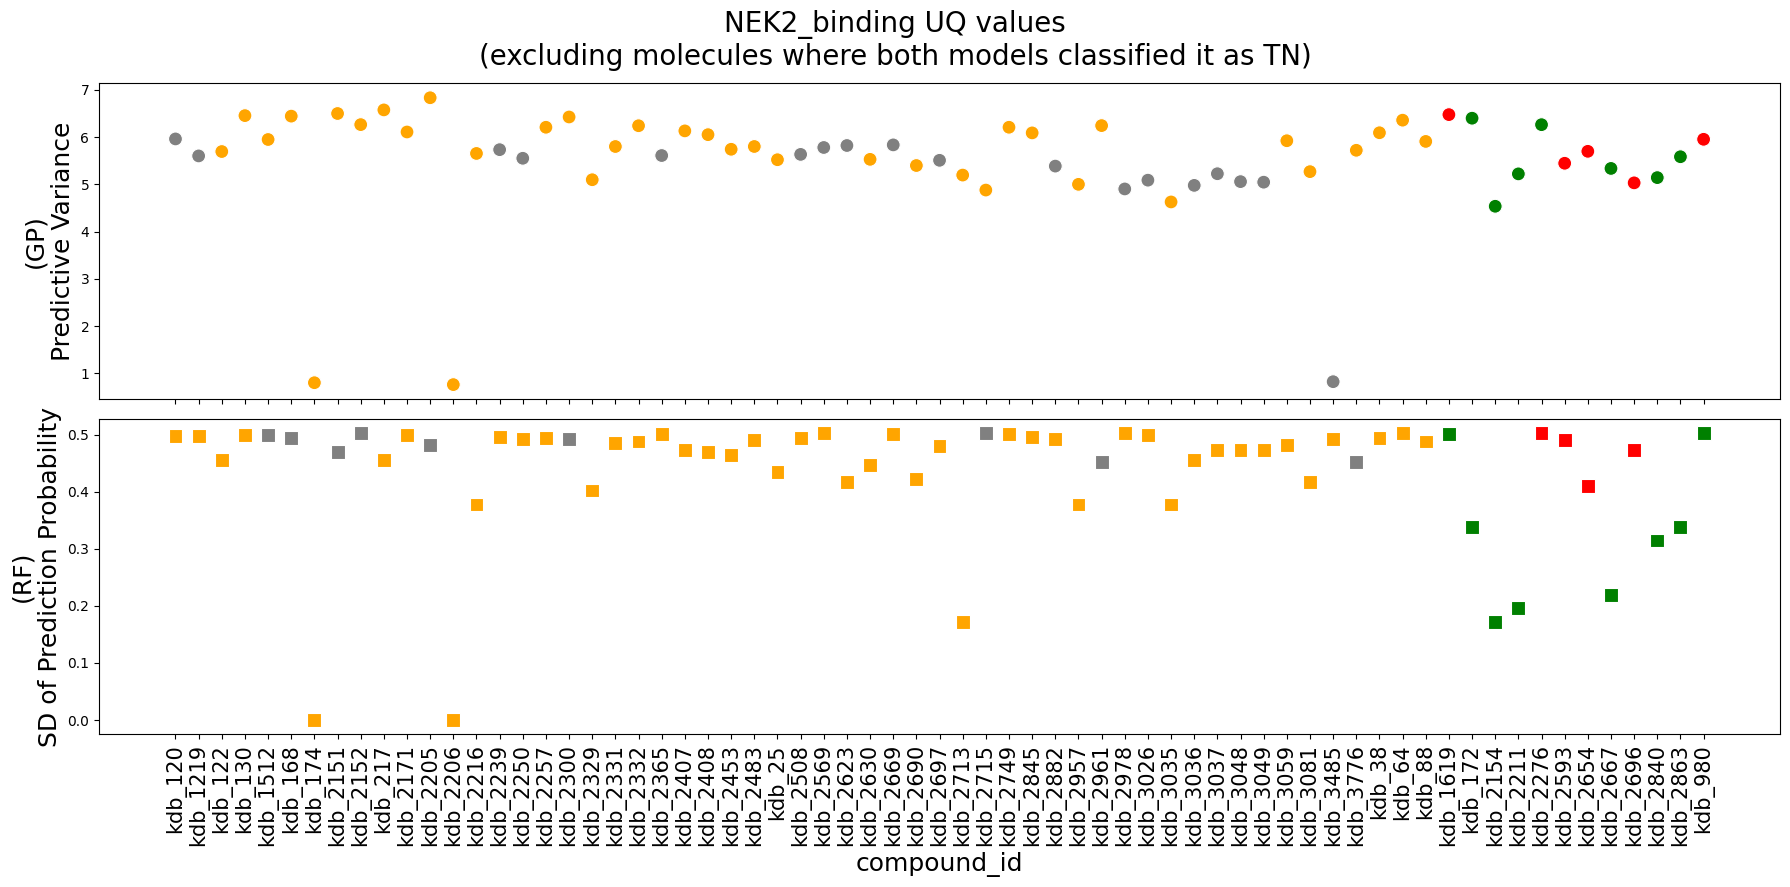

NEK2_inhibition UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK2_inhibition none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

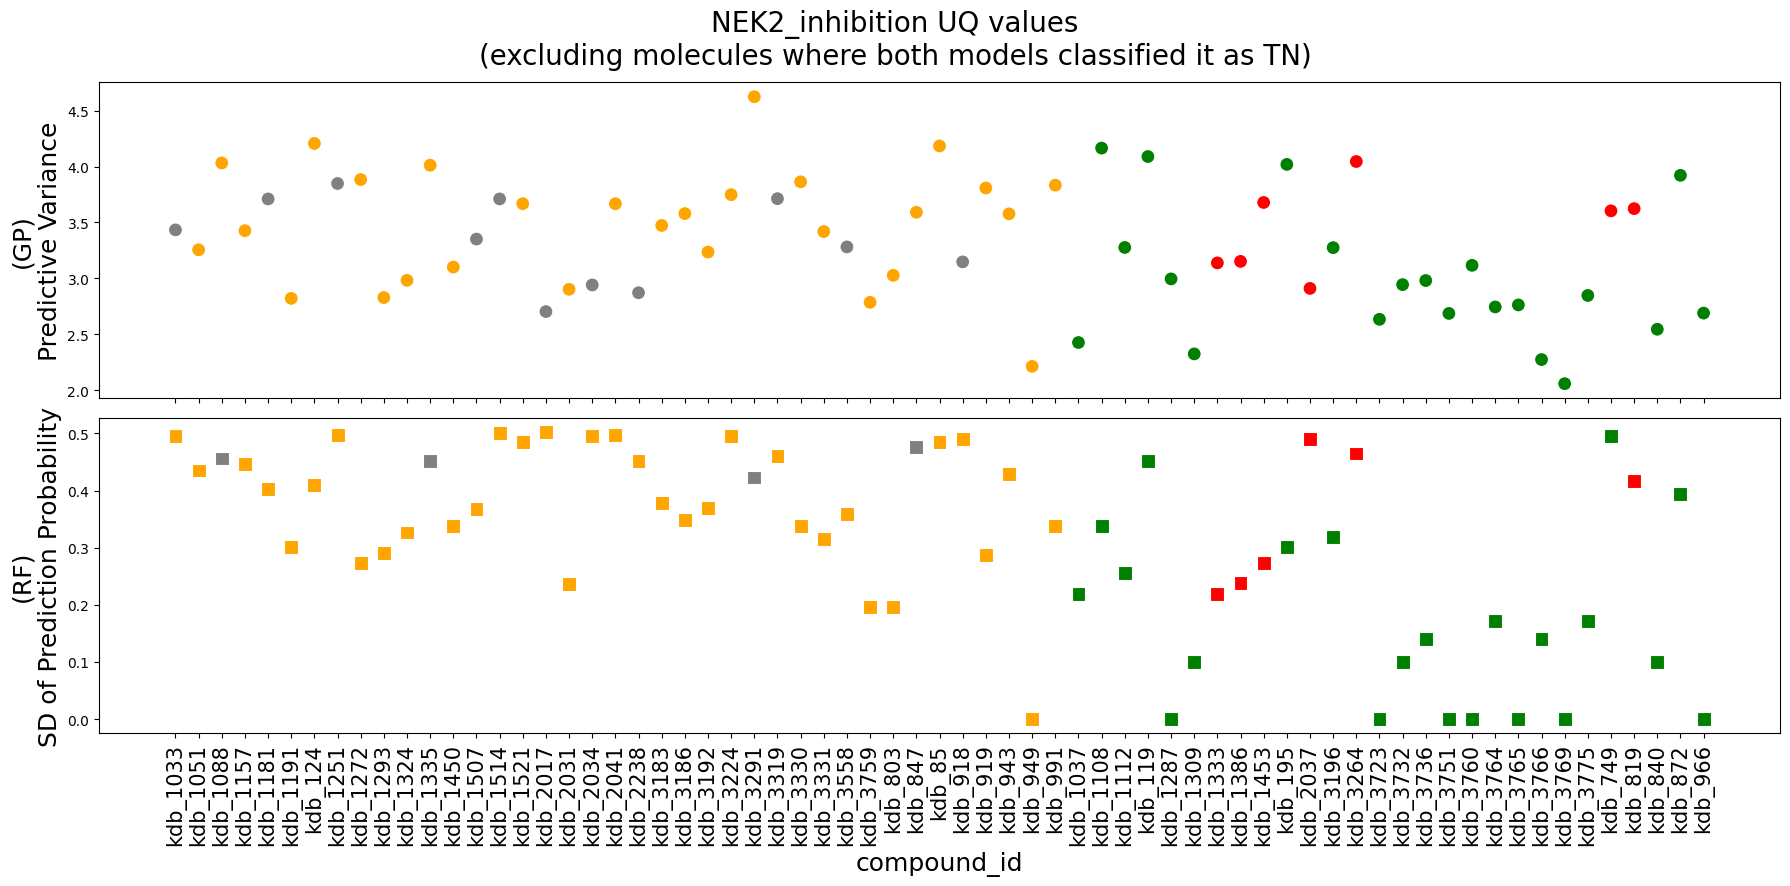

NEK3_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK3_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

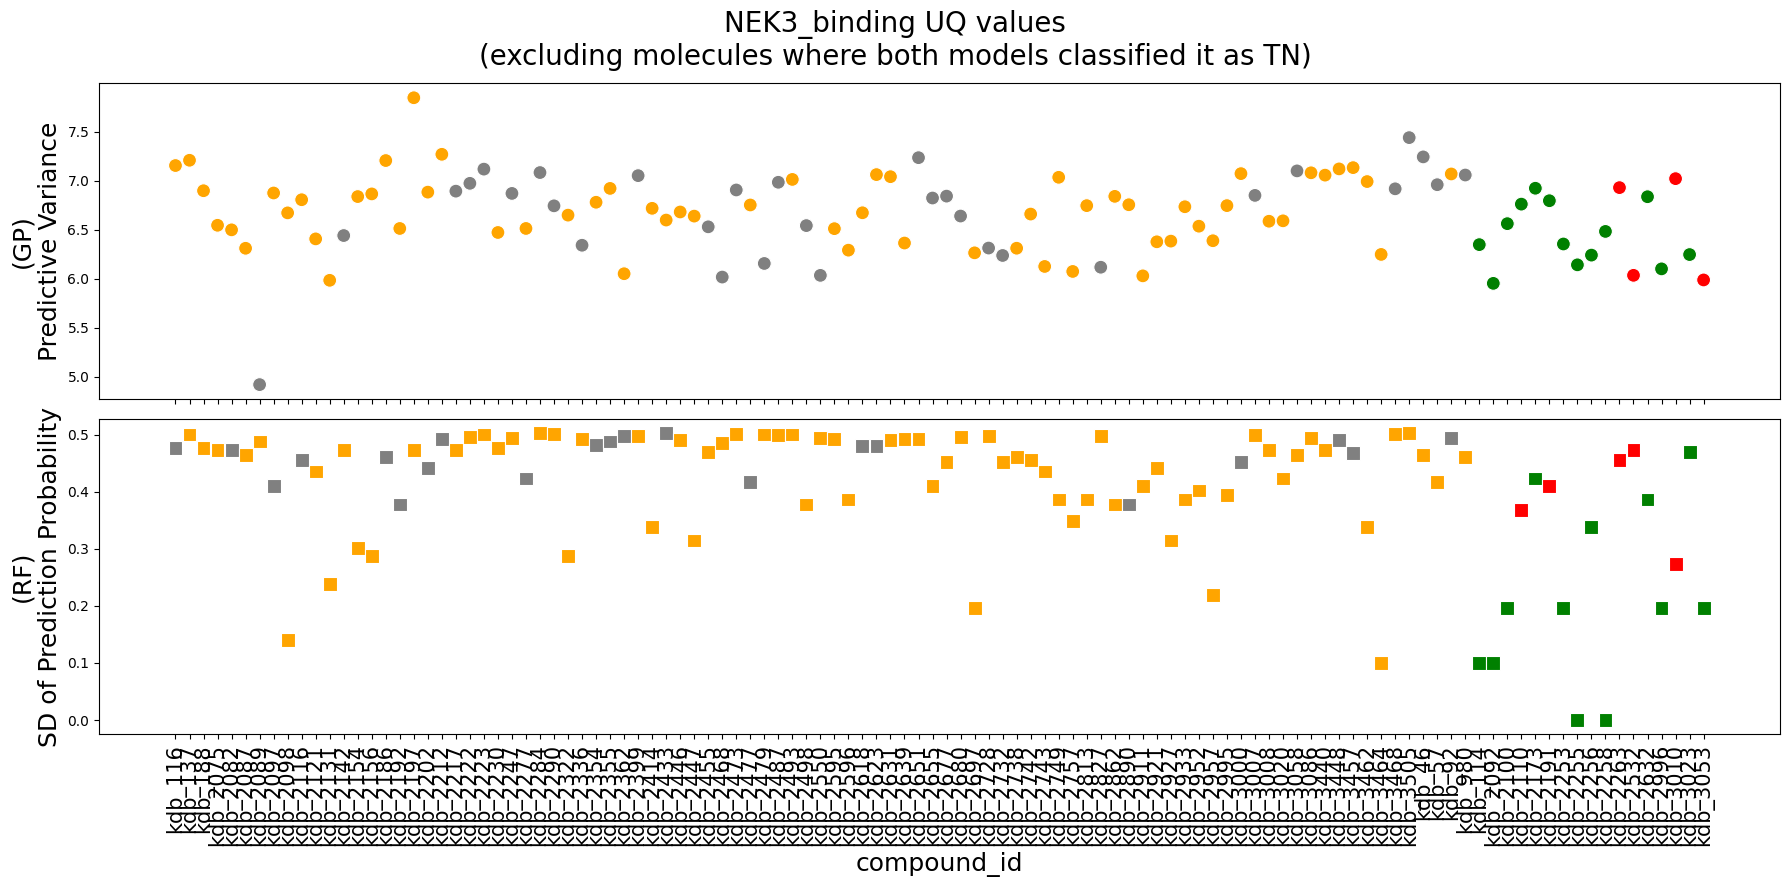

NEK5_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK5_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

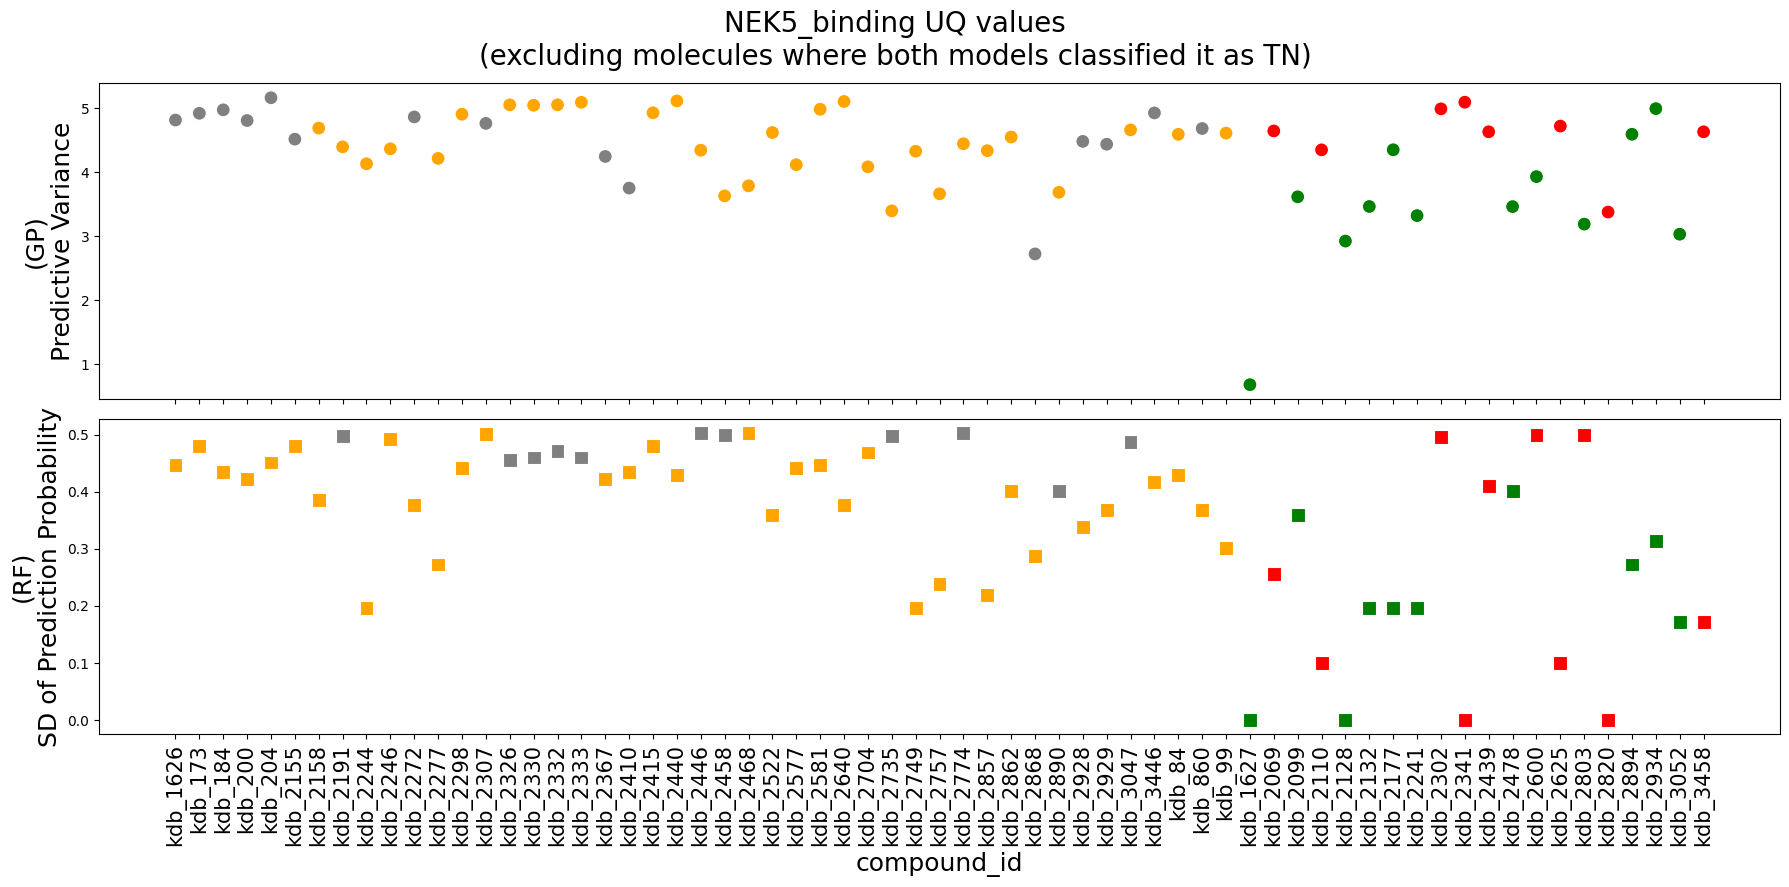

NEK9_binding UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_binding none_scaled_BRFC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

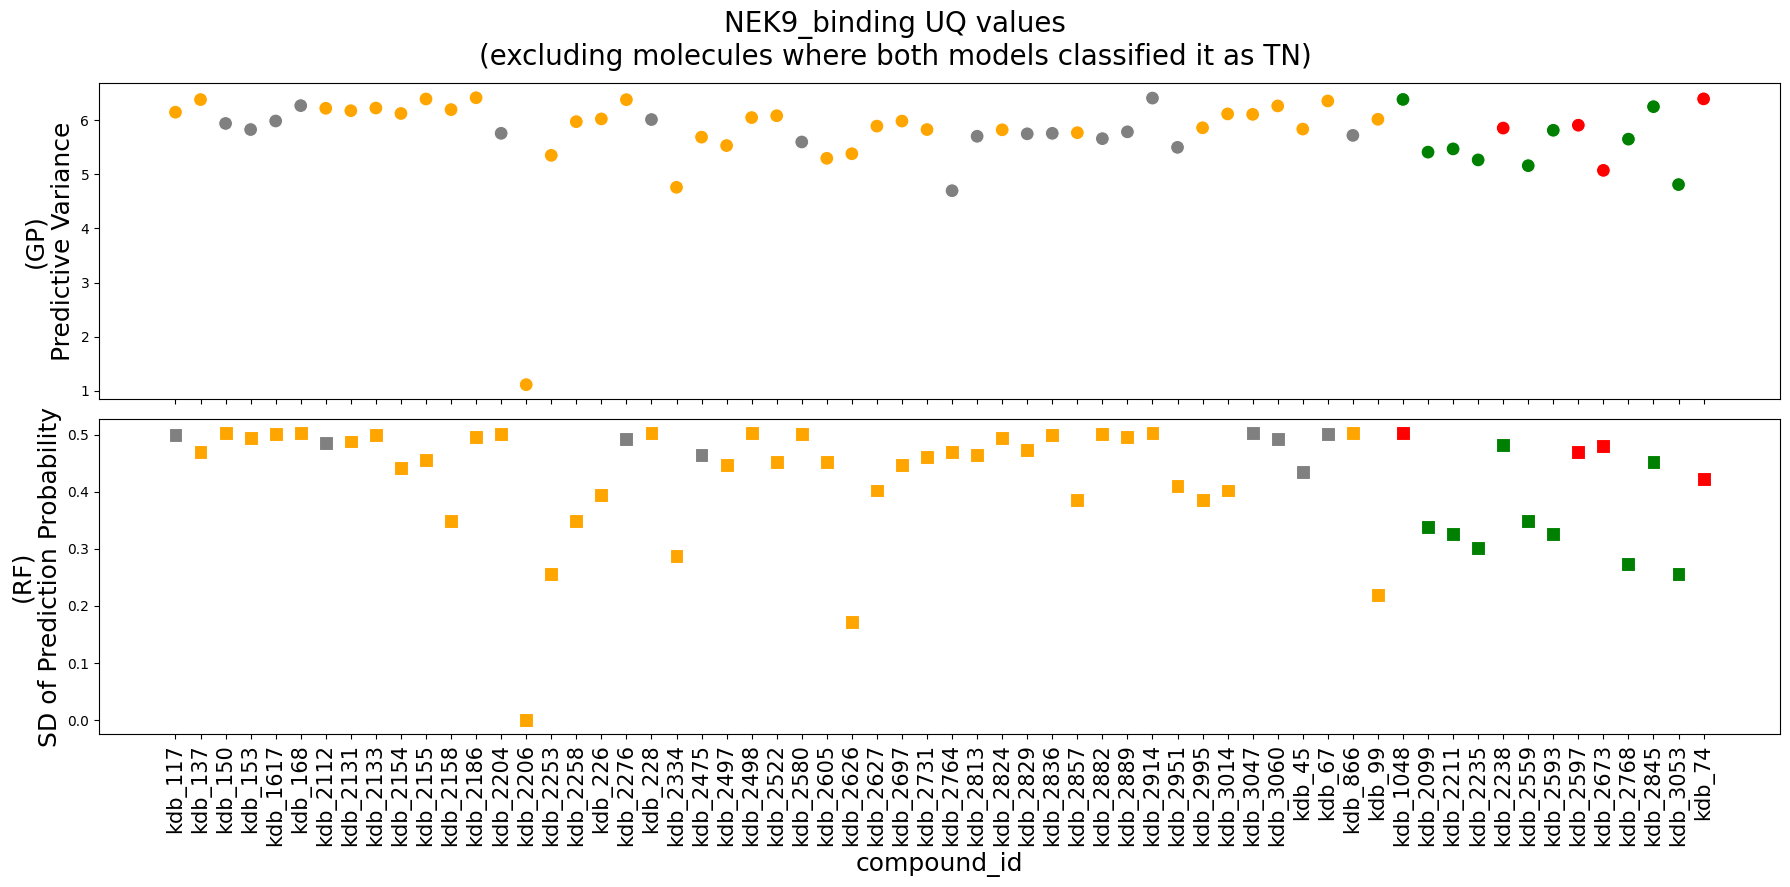

NEK9_inhibition UNDER_GP_matern


<IPython.core.display.Javascript object>

NEK9_inhibition none_scaled_BRFC_BCW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

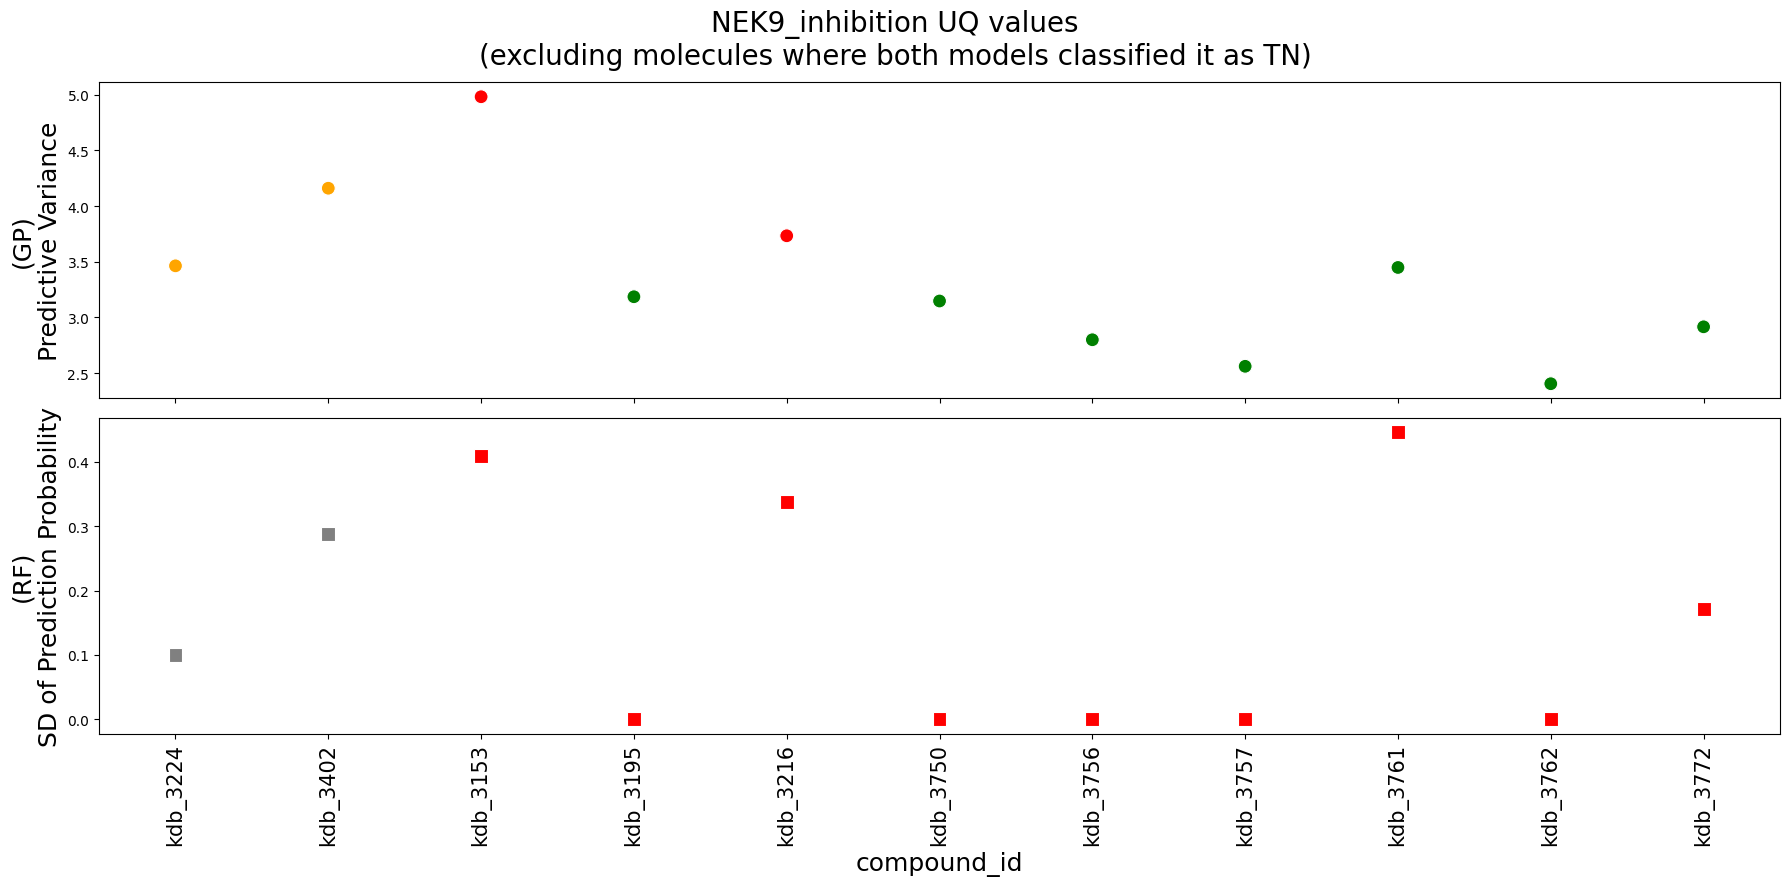

In [213]:
fig_path2='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/compare_across/figs/UQ_point_comparison/not_matching_TN/'
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
for nek in neks:
    df_list = []
    model_list=[]
    for model in ['UNDER_GP_matern','none_scaled_BRFC'] : 
        if (nek=='NEK9_inhibition' and model=='none_scaled_BRFC'): 
            model ='none_scaled_BRFC_BCW'
        print(nek, model)
        model_list.append(model)
        df = pd.read_csv(f'{cmpd_df_path}{nek}_MFP_{model}_cmpd_class.csv')
   
        df_list.append(df) 
    
    merged = df_list[0].merge(df_list[1], on=['compound_id'], suffixes=('_GP', '_RF'))
    mask =(merged['prediction_type_GP']=='TN') & (merged['prediction_type_RF'] == 'TN')
    temp=merged[~mask]
    plot_df = pd.DataFrame({'compound_id':pd.concat([temp['compound_id'],temp['compound_id']]),
    'model': [model_list[0]] * len(temp)+ [model_list[1]]*len(temp),
    'UQ_metric': pd.concat([temp['UQ_metric_value_GP'],temp['UQ_metric_value_RF']]),
    'prediction_type': pd.concat([temp['prediction_type_GP'], temp['prediction_type_RF']])})
    # display(plot_df)
    
    # plt.figure(figsize=(16, 6))
    fig,axs=plt.subplots(nrows=2, ncols=1, figsize=(18,9), sharex=True)
    gp_df = plot_df[plot_df['model']==model_list[0]]
    rf_df =  plot_df[plot_df['model']==model_list[1]]
    # display(plot_df)
   
    sns.scatterplot(data=gp_df,x='compound_id',y='UQ_metric',hue='prediction_type',palette=pred_types,
        style='model',markers=model_shapes, s=100, ax=axs[0],legend=False)
    sns.scatterplot(data=rf_df,x='compound_id',y='UQ_metric',hue='prediction_type',palette=pred_types,
        style='model',markers=model_shapes, s=100, ax=axs[1],legend=False)
    # axs[1].legend(bbox_to_anchor=(1,1))
   
    axs[0].set_xlabel('compound_id',fontsize=18)
    axs[0].set_ylabel('(GP)\nPredictive Variance',fontsize=18)
    axs[1].set_xlabel('compound_id',fontsize=18)
    axs[1].set_ylabel('(RF)\nSD of Prediction Probability',fontsize=18)
    # axs[1].tick_params(labelsize=20)
    fig.subplots_adjust(hspace=0)
    plt.xticks(rotation=90, fontsize=15)
    fig.suptitle(f'{nek} UQ values\n(excluding molecules where both models classified it as TN)',fontsize=20)
    legend2 = [Line2D([0],[0], marker='o', color='black', markerfacecolor='black', markersize=6, label='UNDER GP Matern')]
    
    handles, labels = axs[1].get_legend_handles_labels()
    handles+=legend2
    # axs[1].legend(handles=handles, labels=labels, title='Legend')
 
    plt.tight_layout()
    plt.savefig(f"{fig_path2}{nek}.png", bbox_inches='tight')
    plt.show()
    
        